# Capstone: SG Food Recommender
Author: Choo Wende

---

## Part 2: Exploratory Data Analysis (EDA) and Topic Modelling

## Libraries Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import re
import gensim 
import gensim.corpora as corpora
import spacy

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from matplotlib import image
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## 4. EDA

### Import Data

In [2]:
# Read merged dataframe
df = pd.read_csv('../data/combined_data.csv')
df.shape

C:\Users\Wende.Joanne\AppData\Local\Temp\ipykernel_22208\2023375282.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/combined_data.csv')


(21790, 193)

In [3]:
# Display Dataframe info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21790 entries, 0 to 21789
Columns: 193 entries, rest_name to category_food_stands
dtypes: float64(5), int64(176), object(12)
memory usage: 32.1+ MB


In [4]:
# Display first 2 rows of merged dataframe
df.head(2)

,rest_name,href,address,postal_code,latitude,longitude,opening,img,star_rating,review_count,...,category_izakaya,category_caterers,category_asian_fusion,category_beer,category_irish,category_barbeque,category_mediterranean,category_thai,category_greek,category_food_stands
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,0,0,0,0
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Instantiate dataframe columns
rest_info_col = [
    'rest_name',
    'href',
    'address',
    'postal_code',
    'latitude',
    'longitude',
    'opening',
    'img',
    'star_rating',
    'review_count',
    'location',
    'price_range'
]

user_info_col = [
    'username',
    'userid',
    'user_location',
    'user_rating',
    'review_date',
    'comment'
]

cat_col = df.drop(columns = rest_info_col + user_info_col).columns.tolist()

In [6]:
# Display datatype for non-categorial columns
df[rest_info_col + user_info_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21790 entries, 0 to 21789
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rest_name      21790 non-null  object 
 1   href           21790 non-null  object 
 2   address        21790 non-null  object 
 3   postal_code    21790 non-null  object 
 4   latitude       21790 non-null  float64
 5   longitude      21790 non-null  float64
 6   opening        21790 non-null  object 
 7   img            21790 non-null  object 
 8   star_rating    21790 non-null  float64
 9   review_count   21790 non-null  float64
 10  location       21790 non-null  object 
 11  price_range    21790 non-null  float64
 12  username       21790 non-null  object 
 13  userid         21790 non-null  object 
 14  user_location  21790 non-null  object 
 15  user_rating    21790 non-null  int64  
 16  review_date    21790 non-null  object 
 17  comment        21790 non-null  object 
dtypes: flo

In [7]:
# Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

### Map Overview of Restaurant Locations

In [8]:
# load image as pixel array
sg_map_data = image.imread('../data/sg_map_grayscale.png')

# summarize shape of the pixel array
print(sg_map_data.dtype)
print(sg_map_data.shape)

# Define longitude and latitude for sg_map
lon_lat_boundary = (103.6, 104.1, 1.2, 1.5)


float32
(803, 1342)


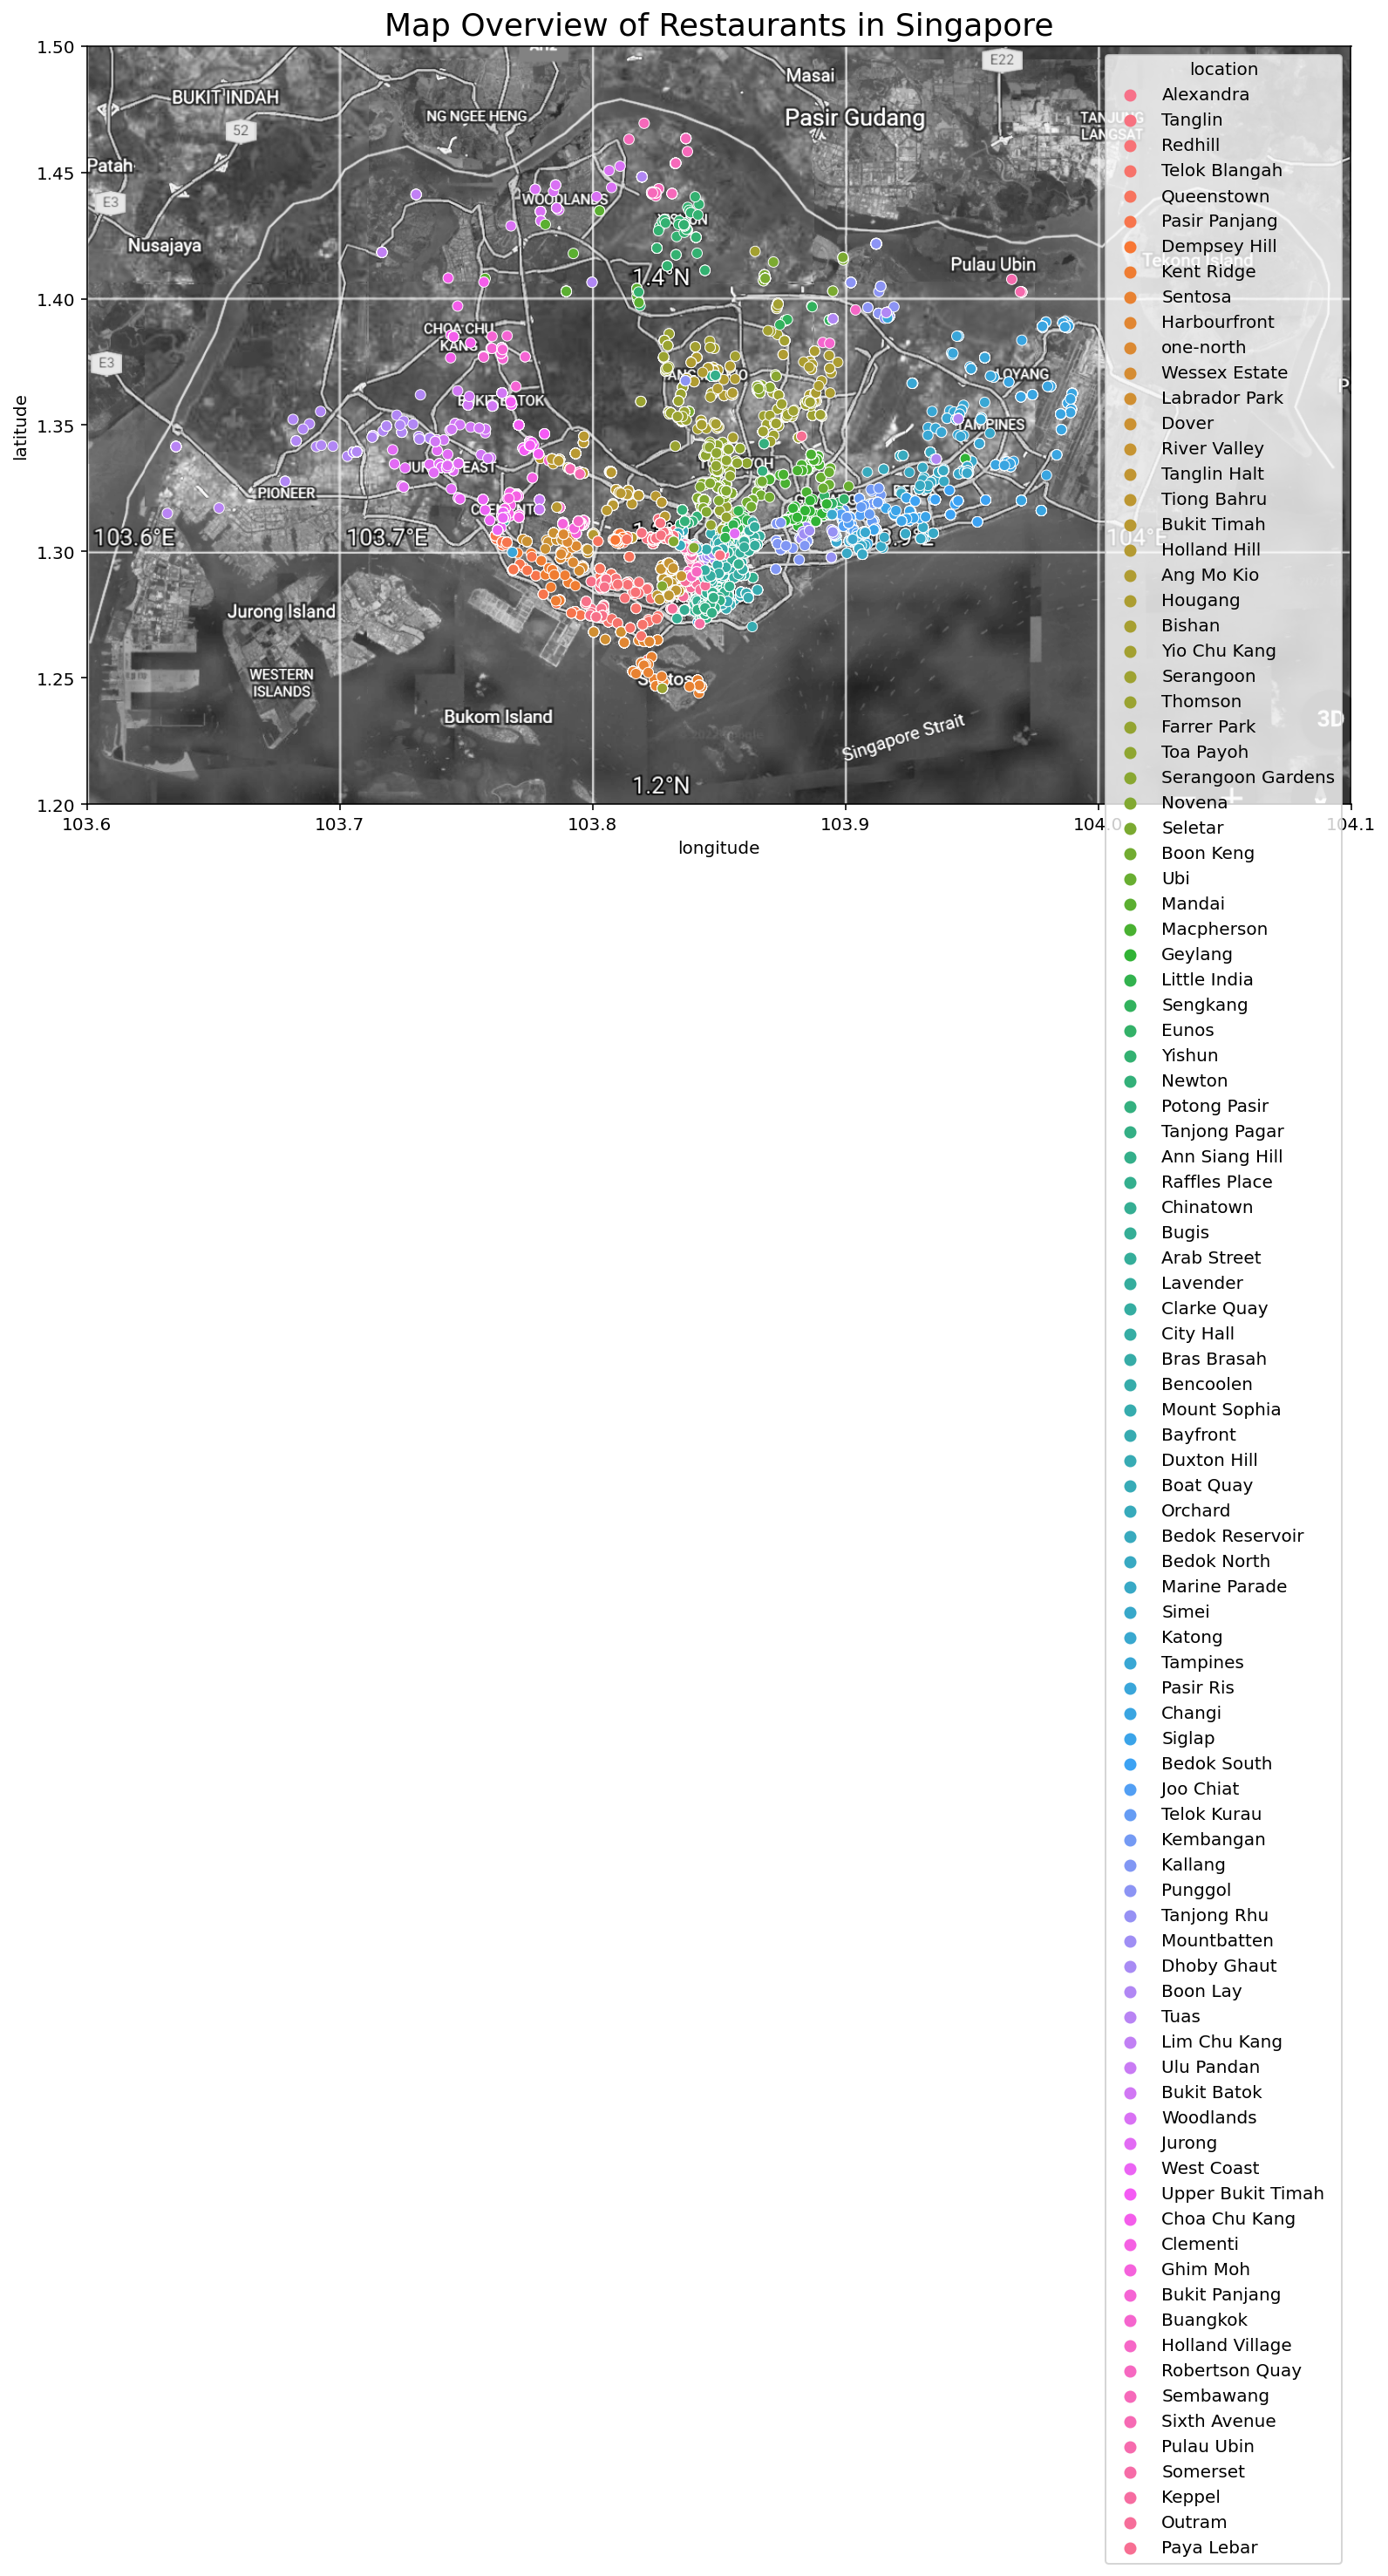

In [9]:
# Plot overview of restaurant locations
plt.figure(figsize=(15,8))
plt.title('Map Overview of Restaurants in Singapore', size=18)
plt.imshow(sg_map_data, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_boundary);
sns.scatterplot(data=df, y='latitude', x='longitude', hue='location');

### Reviews Density Per Restaurant
1. There are a total of 3,938 restaurants, with an average of about 6 comments per restaurants.
2. However, majority of the restaurants have between 1 and 6 reviews.
3. This is assessed to be adequate to build the recommendation system. 

In [10]:
# Create dataframe of restaurants and review count
comment_count_df = df.groupby(['rest_name', 'href']).count()[['comment']].sort_values(by='comment', ascending=False)
comment_count_df = comment_count_df.reset_index(drop=False)
comment_count_df.head()

,rest_name,href,comment
0,Tian Tian Hainanese Chicken Rice,http://www.yelp.com/biz/tian-tian-hainanese-ch...,202
1,Song Fa Bak Kut Teh,http://www.yelp.com/biz/song-fa-bak-kut-teh-si...,128
2,Zam Zam Restaurant,http://www.yelp.com/biz/zam-zam-restaurant-sin...,92
3,Vatos Urban Tacos,http://www.yelp.com/biz/vatos-urban-tacos-sing...,90
4,Two Men Bagel House,http://www.yelp.com/biz/two-men-bagel-house-si...,76


In [11]:
# Describe review counts of restaurants
comment_count_df.describe()

,comment
count,3938.000000
mean,5.533266
std,8.636805
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,202.000000


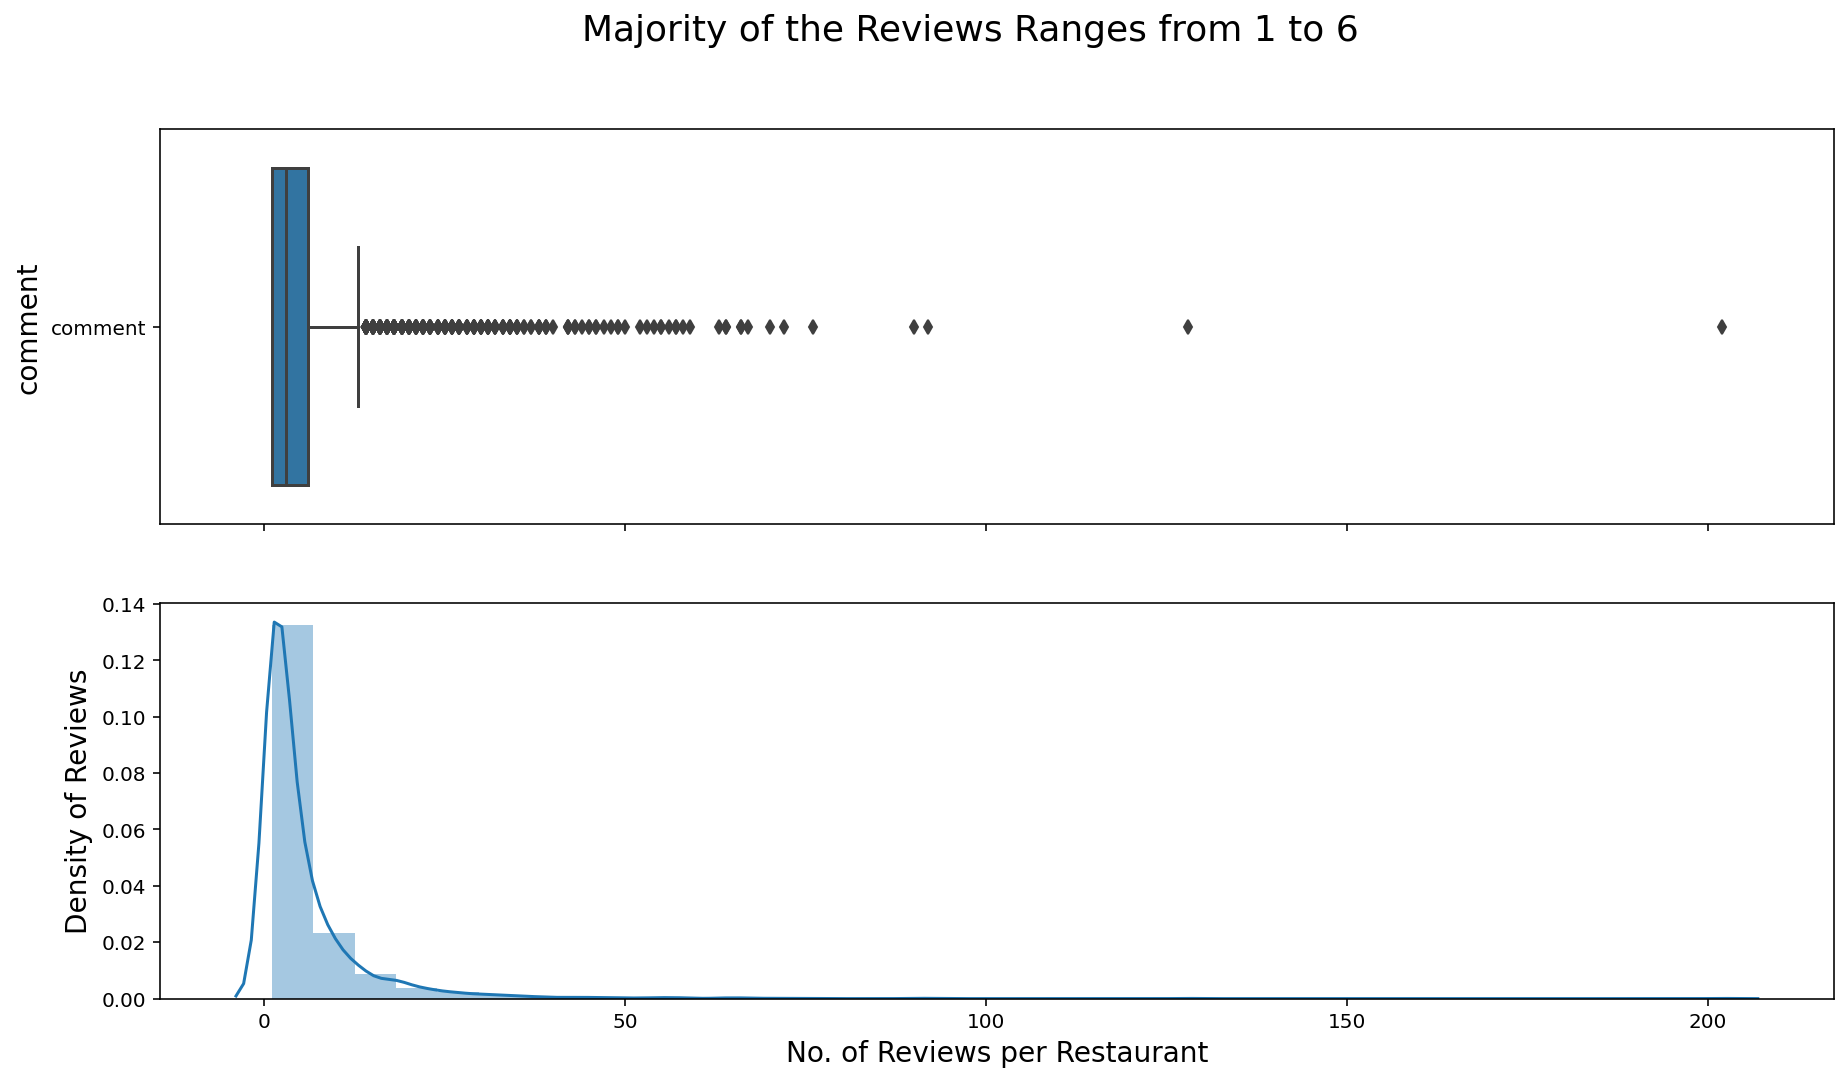

In [12]:
# Boxplot and distribution plot of reviews per restaurants
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 8))
ax = ax.ravel()

plt.suptitle("Majority of the Reviews Ranges from 1 to 6", size=18)

# Boxplot of review counts per restaurant
sns.boxplot(data=comment_count_df, orient='h', ax=ax[0])
ax[0].set_ylabel("comment", size=14)

# Plotting the distribution
sns.distplot(comment_count_df["comment"],  
             bins=35,
             ax=ax[1])
ax[1].set_xlabel("No. of Reviews per Restaurant", size=14)
ax[1].set_ylabel("Density of Reviews", size=14)

plt.show()

### Reviews Density Per User
1. There are a total of about 6,700 users, with an average of about 3 review submissions per user.
2. However, majority of the users(about 5,000) have either 1 or 2 reviews.
3. To build the recommendation system, users with more than 3 reviews will be considered. This will amount to a user base of about 1000 users. This is assessed to be adequate to build the recommender system. 
4. For users with more than 3 review submissions, the average number of reviews per user is about 13 submissions. Majority of the users submits between 5 and 13 reviews.

In [13]:
# Create a dataframe of review counts based on users. 
user_count_df = df.groupby(['username', 'userid']).count()[['comment']].sort_values(by='comment', ascending=False)
user_count_df = user_count_df.reset_index()

# Display top 5 users based on highest review submissions 
user_count_df.head()

,username,userid,comment
0,Doreen T.,2F38Uc4UNNbFVdyUUnBjOA,290
1,Ancy N.,4y4obgWxi_CL25nRHrhuEA,173
2,Melissa Y.,H8mXfh5XgGCqmMLwVH7k5A,145
3,Lam N.,Y4pO9yZociD96rtJ5vRyDw,142
4,Carolyn L.,Q1oMmm7tKPOzA7_gqcV4zg,137


In [14]:
# Describe the dataframe
user_count_df.describe()

,comment
count,6765.000000
mean,3.220990
std,9.308392
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,290.000000


In [15]:
# there are about 1,000 users with more than 3 review submissions. 
user_base_df = user_count_df[user_count_df['comment']>3]
len(user_base_df)

1029

In [16]:
# Describe the dataframe for users with more than 3 reviews submissions
user_base_df.describe()

,comment
count,1029.000000
mean,13.834791
std,20.859543
min,4.000000
25%,5.000000
50%,7.000000
75%,13.000000
max,290.000000


In [17]:
# Get the total number of reviews for users with more than 3 reviews submissions
user_base_df['comment'].sum()

14236

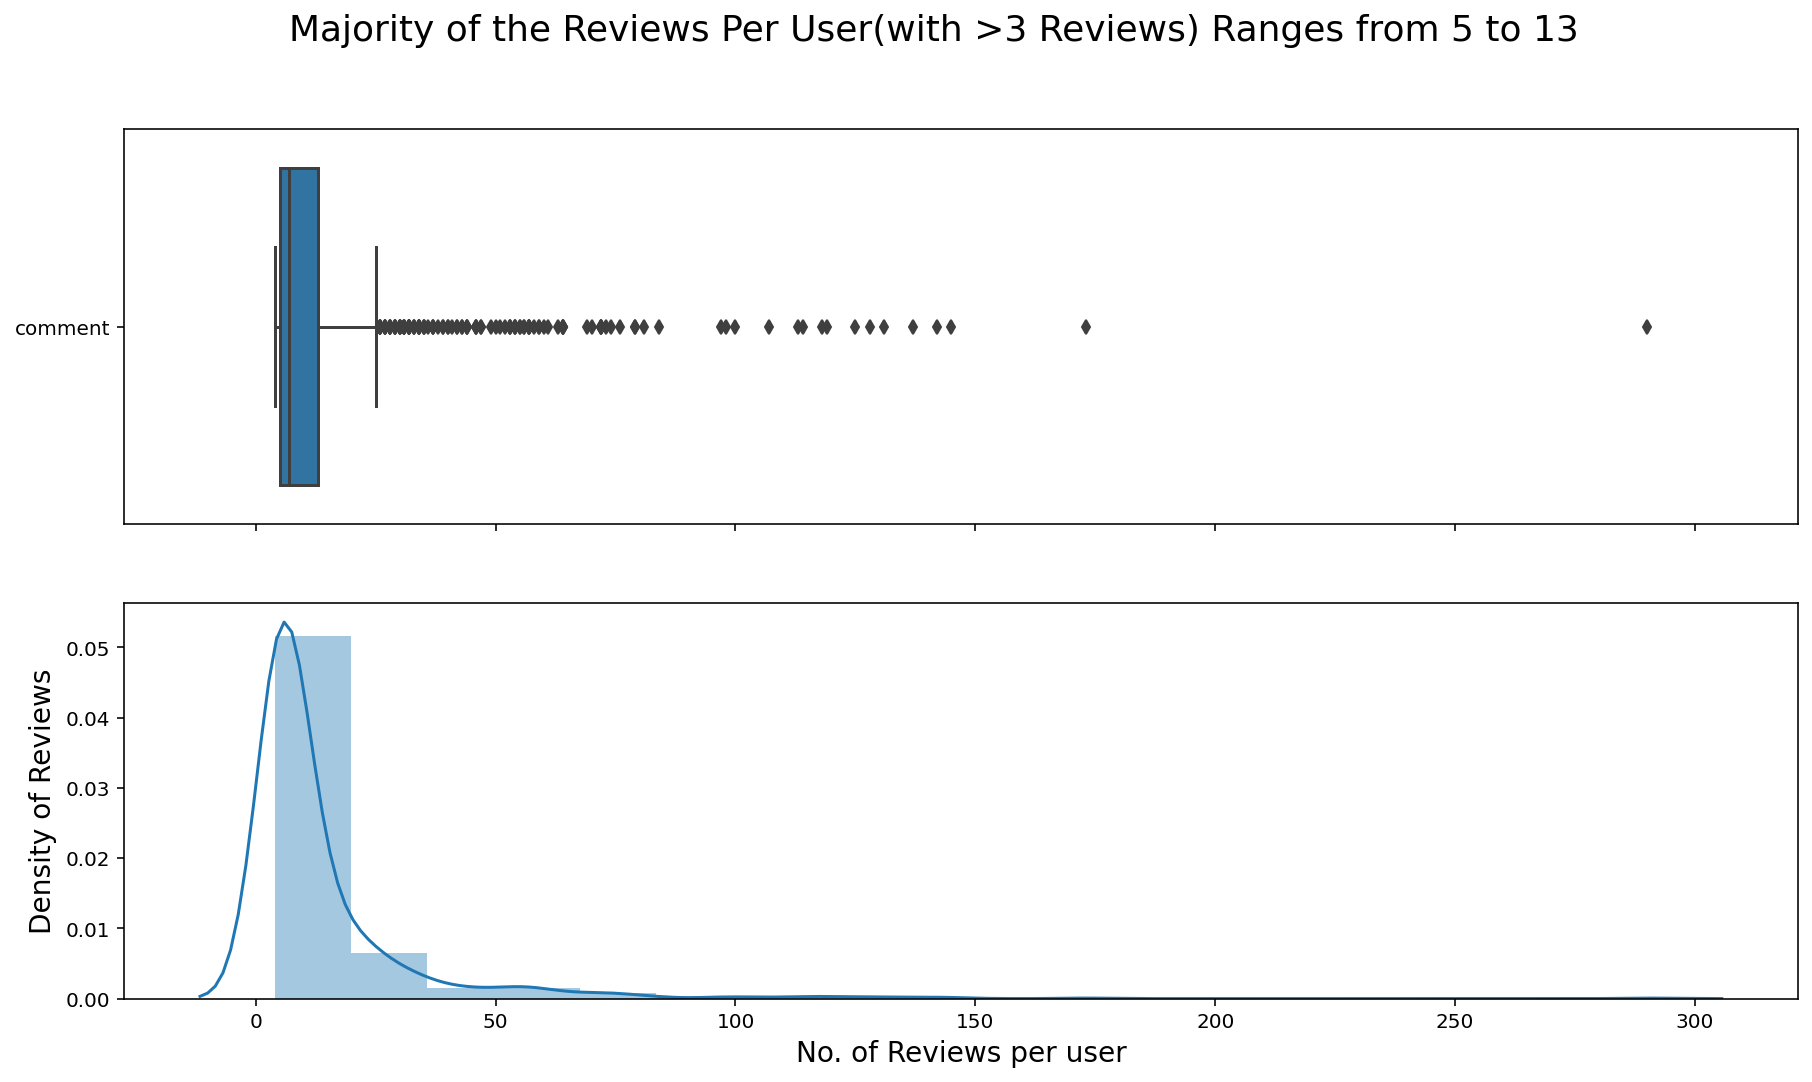

In [18]:
# Boxplot and distribution plot of reviews per user with more than 3 reviews submissions
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 8))
ax = ax.ravel()

plt.suptitle("Majority of the Reviews Per User(with >3 Reviews) Ranges from 5 to 13", size=18)

# Box plot of reviews per user
sns.boxplot(data=user_base_df, orient='h', ax=ax[0])

# Plotting the distribution
sns.distplot(user_base_df["comment"],
             bins=18, 
             ax=ax[1])
ax[1].set_xlabel("No. of Reviews per user", size=14)
ax[1].set_ylabel("Density of Reviews", size=14)

plt.show()

### Reviews Count by Users' Origin
1. There are 1,512 local users and 5,253 overseas users. 
2. 9,847 reveiws are submitted by locals while 11,943 reviews are submitted by overseas users. 
3. On average, local users submit about 5 reviews while overseas users submit about 2 reviews

In [19]:
# Create label to identify local user
df['local_user'] = df['user_location'].map(lambda x: 1 if x == 'Singapore, Singapore' else 0)

In [20]:
# Get the number of local users and overseas users. 
df[['local_user', 'userid']].drop_duplicates()['local_user'].value_counts()

0    5253
1    1512
Name: local_user, dtype: int64

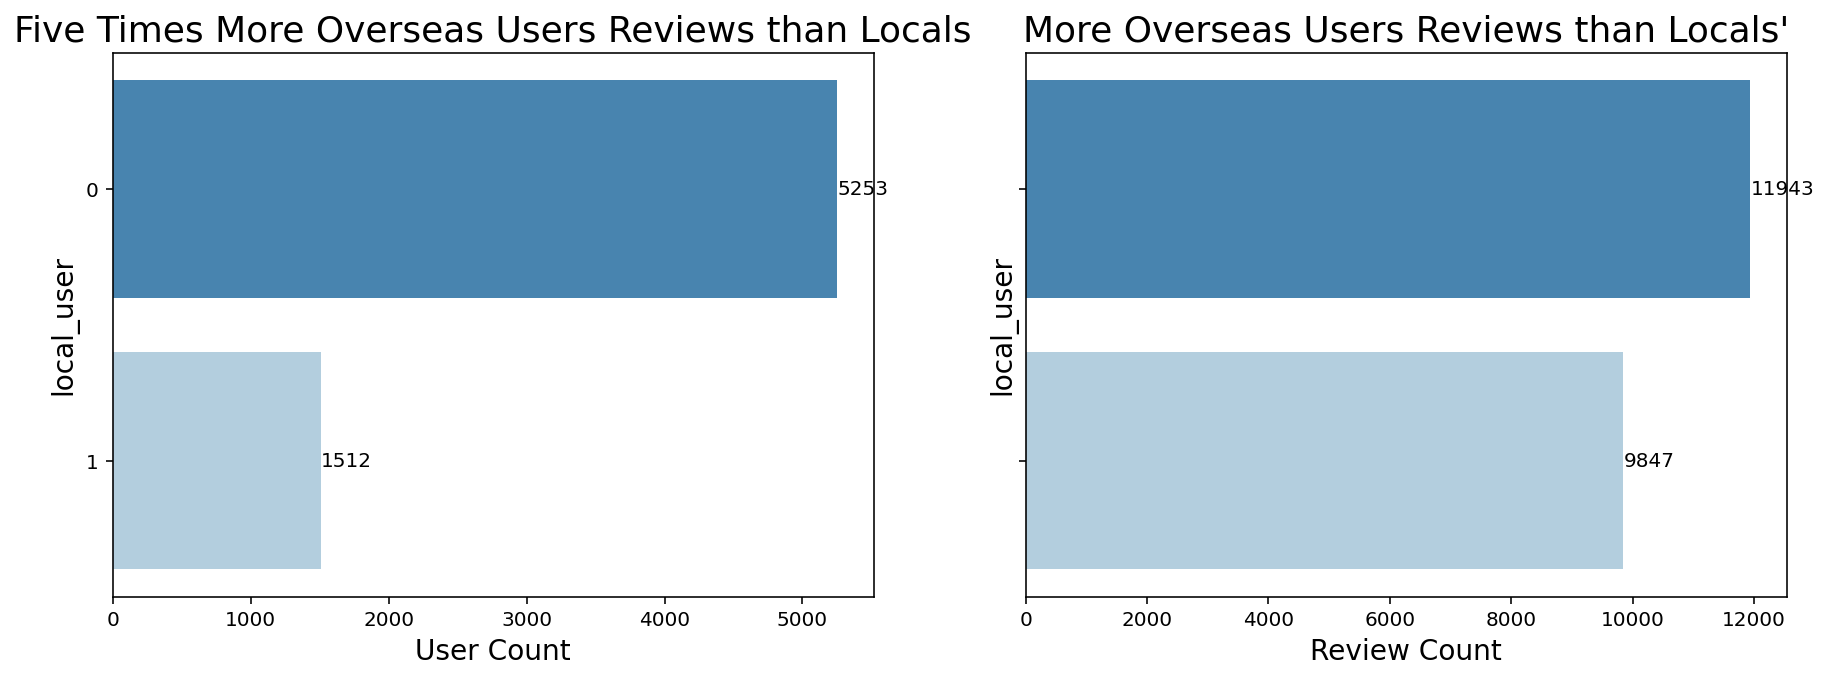

In [21]:
# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 5))

# Plot proportion by users by origin.
sns.barplot(x=df[['local_user', 'userid']].drop_duplicates()['local_user'].value_counts().values,
            y=df[['local_user', 'userid']].drop_duplicates()['local_user'].value_counts().index, 
            orient='h',
            palette='Blues_r', 
            ax=ax[0])
ax[0].set_xlabel("User Count", size=14)
ax[0].set_ylabel("local_user", size=14)
ax[0].set_title('Five Times More Overseas Users Reviews than Locals', size=18)
ax[0].bar_label(ax[0].containers[0]);

# Plot reviews by users origin.
sns.barplot(x=df.groupby(by=['local_user']).count()['comment'].values,
            y=df.groupby(by=['local_user']).count()['comment'].index, 
            orient='h',
            palette='Blues_r', 
            ax=ax[1])
ax[1].set_xlabel("Review Count", size=14)
ax[1].set_ylabel("local_user", size=14)
ax[1].set_title('More Overseas Users Reviews than Locals\'', size=18)
ax[1].bar_label(ax[1].containers[0]);

### Reviews Density by Year
1. There is significant reduction in reviews submitted in 2020 and 2021. This is likely due to the COVID-19 measures where restaurants are closed or reduction in number of persons allowed to dine out. People have also switched to food delivery services and provided review on these platforms. 
2. In 2022, there is an increasing trend of reviews submission. This is likely due to the easing of COVID-19 restrictions. 

In [22]:
# Create Dataframe for reviews by year.
review_yr_df = df.review_date.dt.year.value_counts().reset_index()
review_yr_df.rename(columns = {'index':'review_yr', 
                               'review_date':'review_count'}, 
                    inplace=True)

review_yr_df

,review_yr,review_count
0,2016,3481
1,2015,3211
2,2017,2649
3,2012,2636
4,2014,2284
5,2018,2215
6,2013,2166
7,2019,1952
8,2020,660
9,2022,277


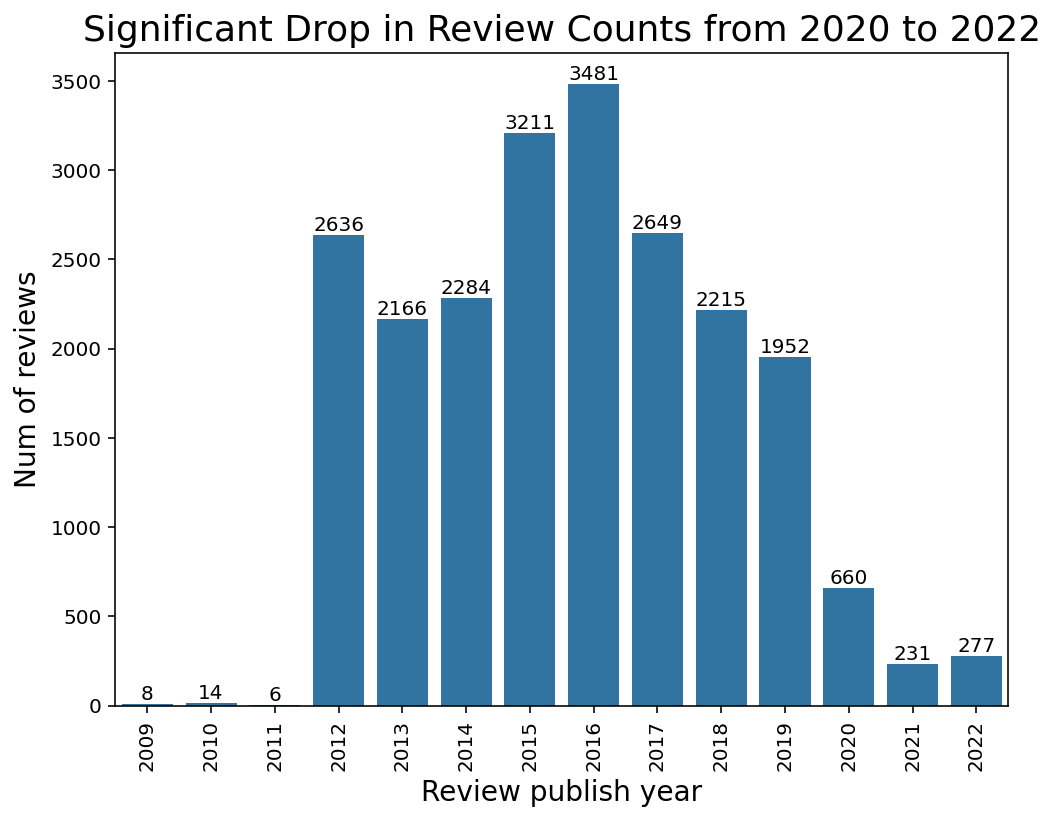

In [23]:
# Plotting in a bar graph of review count by year

plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
plt.title("Significant Drop in Review Counts from 2020 to 2022", fontsize=18)

ax = sns.barplot(x="review_yr", y="review_count", data=review_yr_df, orient="v", color="tab:blue")
ax.set_xlabel("Review publish year", size=14)
ax.set_ylabel("Num of reviews", size=14)
ax.bar_label(ax.containers[0]);

### Reviews Density by Month
1. Generally, there are higher number reviews between Jul and Sep. 
2. Review count is highest in August as there is spike in review submissions in August 2012. This is because Yelp was first introduced in Singapore in Aug/Sep 2012 ([source](https://en.wikipedia.org/wiki/Yelp)). 

In [24]:
# Create Dataframe for reviews by year.
review_mth_df = df.review_date.dt.month.value_counts().reset_index()
review_mth_df.rename(columns = {'index':'review_mth', 
                               'review_date':'review_count'}, 
                    inplace=True)

review_mth_df

,review_mth,review_count
0,8,2750
1,7,2061
2,9,2024
3,1,1934
4,3,1756
5,12,1720
6,11,1720
7,5,1620
8,10,1615
9,2,1556


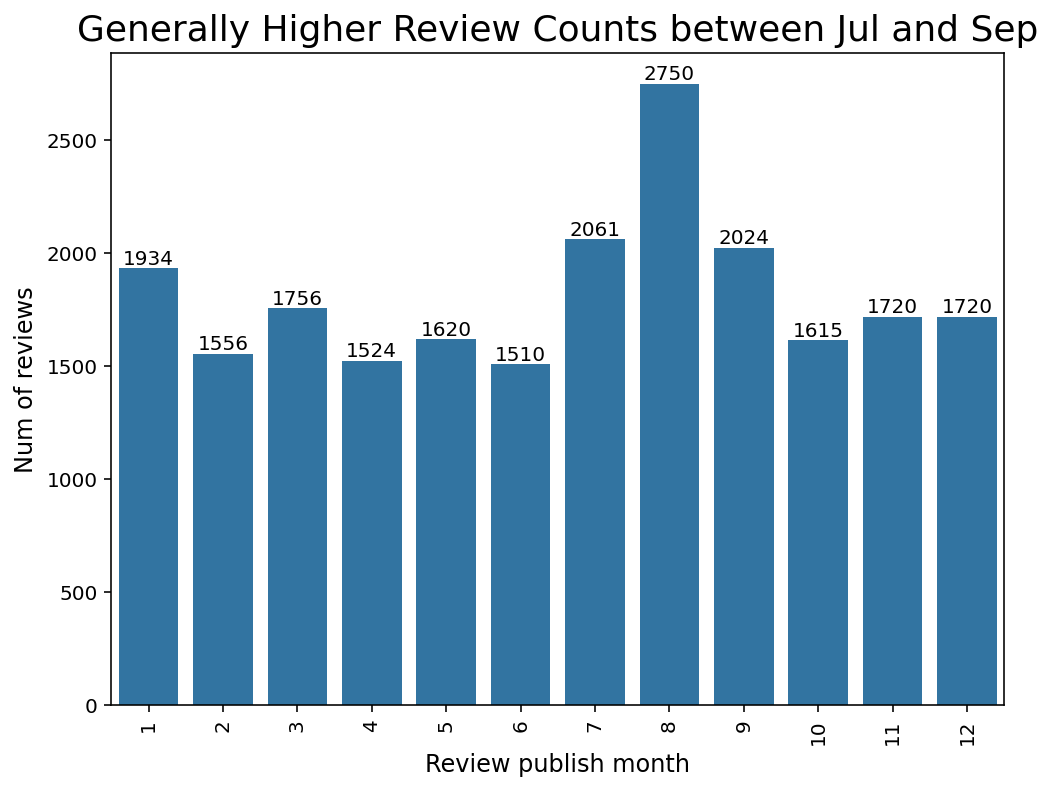

In [25]:
# Plotting in a bar graph of review count by month
plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
plt.title("Generally Higher Review Counts between Jul and Sep", fontsize=18)

ax = sns.barplot(x="review_mth", y="review_count", data=review_mth_df, orient="v", color="tab:blue")
ax.set_xlabel("Review publish month", size=12)
ax.set_ylabel("Num of reviews", size=12)
ax.bar_label(ax.containers[0]);

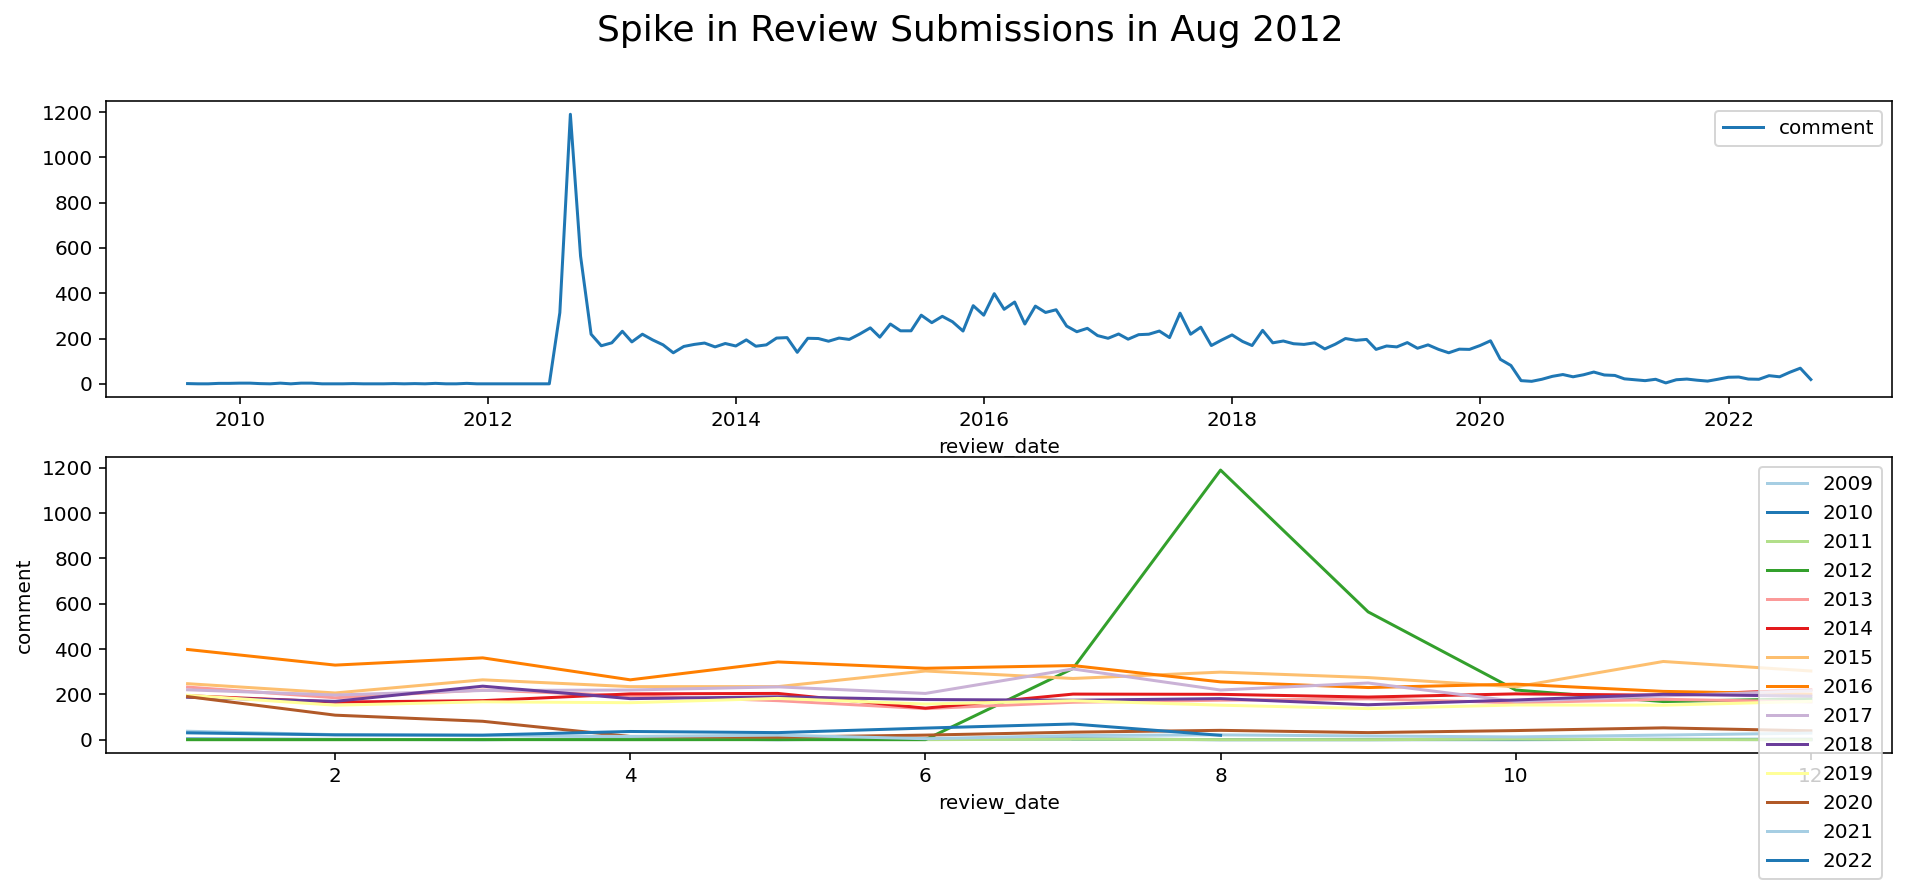

In [26]:
fig, ax = plt.subplots(nrows=2, figsize=(16,6))
plt.suptitle('Spike in Review Submissions in Aug 2012', size=18)

# Plot lineplot of review count by month
sns.lineplot(data=df.groupby(by='review_date').count()[['comment']].resample('M').sum(),
             ax=ax[0]);

# Plot lineplot of review count by month
sns.lineplot(data=df.groupby(by='review_date').count()[['comment']].resample('M').sum(), 
             x=df.groupby(by='review_date').count()[['comment']].resample('M').sum().index.month, 
             y='comment', 
             hue=df.groupby(by='review_date').count()[['comment']].resample('M').sum().index.year,
             palette='Paired',
             ax=ax[1],
             ci=False)
ax[1].legend(loc='upper right');

### Reviews Density Per Category
1. There are a total of 175 categories, with an average of about 210 review submissions per catrgories.
2. However, majority of the categories have between 9 and 253 reviews.
3. The top three categories with the most number of reviews are Chinese, Cafes and Seafood. 

In [27]:
# Create Dataframe for categories review count. 
cat_sum_df = pd.DataFrame(df[cat_col].sum().sort_values(ascending=False), columns=['sum'])

# Print shape of categories review count dataframe
print(cat_sum_df.shape)

# Display top 20 categories baseed on number of reviews. 
cat_sum_df.head(20)

(175, 1)


,sum
category_chinese,2710
category_cafes,2181
category_seafood,1535
category_japanese,1492
category_singaporean,1398
category_bars,1306
category_indian,1250
category_italian,1186
category_asian_fusion,1171
category_breakfast_&_brunch,1149


In [28]:
# Describe number of reviews per category
cat_sum_df.describe()

,sum
count,175.0000
mean,210.0000
std,393.1301
min,0.0000
25%,9.5000
50%,38.0000
75%,253.0000
max,2710.0000


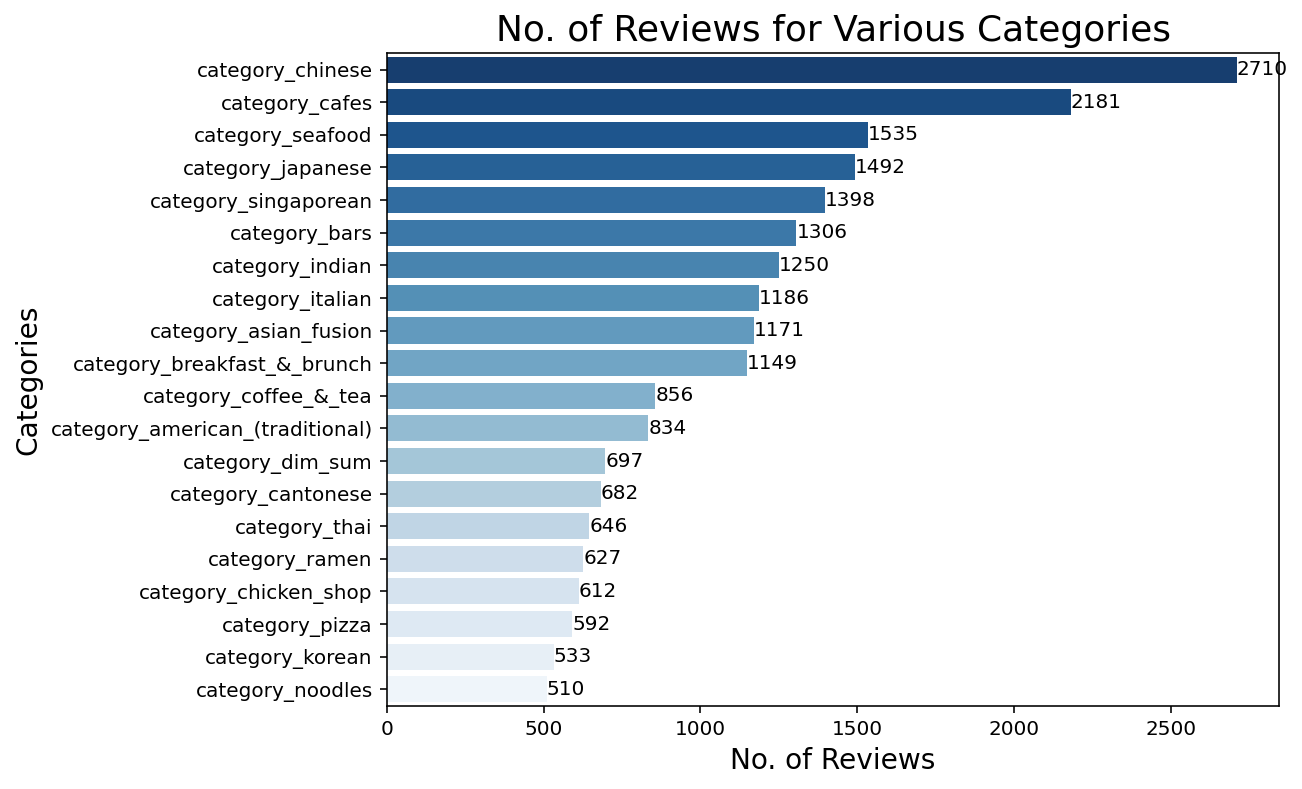

In [29]:
# plot top categories by review count. 
plt.figure(figsize=(8, 6))
plt.title("No. of Reviews for Various Categories", fontsize=18)
ax = sns.barplot(data=cat_sum_df.head(20), 
                 y=cat_sum_df.head(20).index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("No. of Reviews", size=14)
ax.set_ylabel("Categories", size=14)
ax.bar_label(ax.containers[0]);

### Ratings for Various Categories

In [30]:
# Create dataframe to store ratings for various categories. 
cat_mean_df = pd.DataFrame()

for i, cat in enumerate(cat_col):
    temp_df = df.groupby(by = cat).mean().reset_index(drop=False)
    
    try:
        cat_mean_df.loc[i, 'category'] = cat
        cat_mean_df.loc[i, 'avg_user_rating'] = temp_df.loc[1, 'user_rating']
    except:
        continue
    
# Sort user ratings and display first 5 rows of dataframe
cat_mean_df = cat_mean_df.sort_values(by='avg_user_rating', ascending=False)
cat_mean_df.head()

,category,avg_user_rating
68,category_party_&_event_planning,5.000000
15,category_acai_bowls,5.000000
119,category_moroccan,5.000000
81,category_pets,4.750000
11,category_coffee_roasteries,4.666667


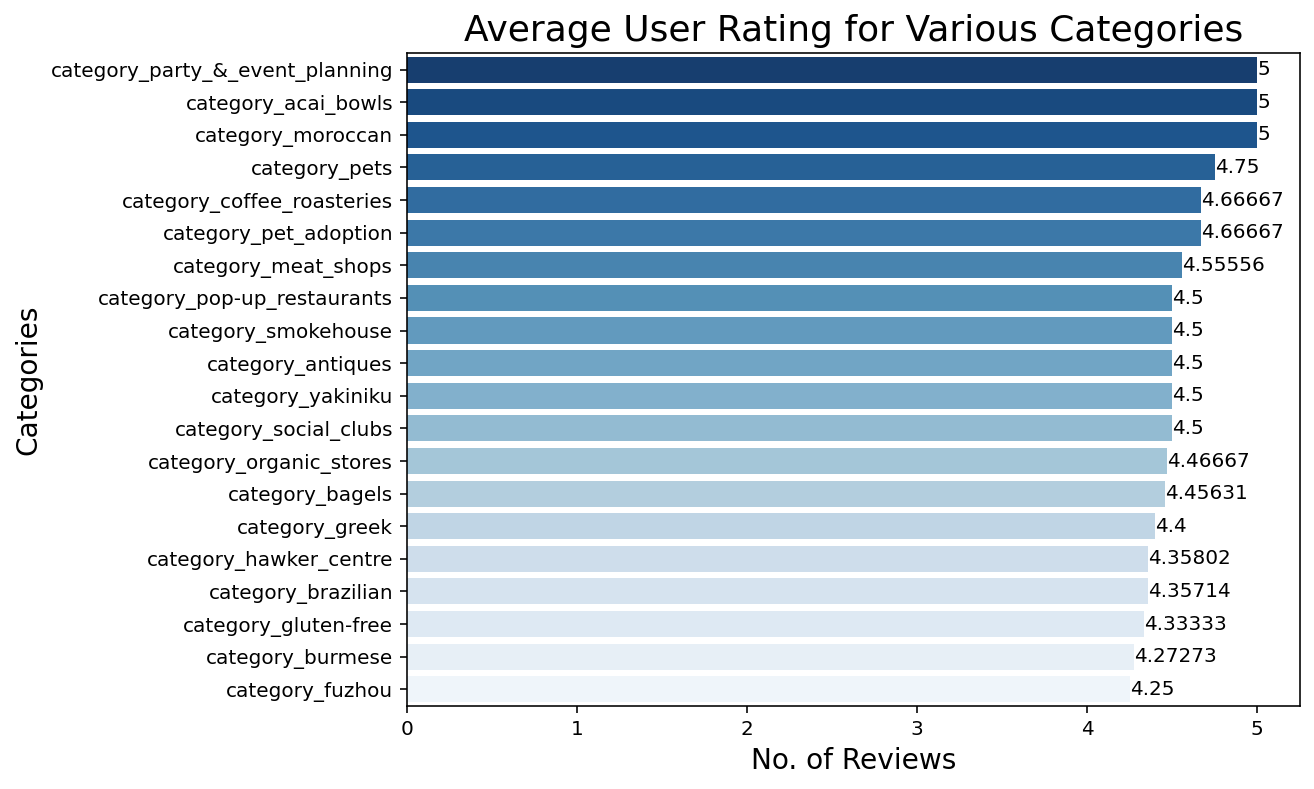

In [31]:
plt.figure(figsize=(8, 6))
plt.title("Average User Rating for Various Categories", fontsize=18)
ax = sns.barplot(data=cat_mean_df.head(20), 
                 y='category', 
                 x='avg_user_rating', 
                 palette='Blues_r');
ax.set_xlabel("No. of Reviews", size=14)
ax.set_ylabel("Categories", size=14)
ax.bar_label(ax.containers[0]);

### Distribution of Ratings
1. Majority of the users submited rating from 3 to 5. 
2. Most users submitted a rating of 4.
3. The average rating is about 3.8. This shall be the rating limit to determine for a restaurant to be relevant to the users. 

In [32]:
# Describe `user_rating` column
df[['user_rating']].describe()

,user_rating
count,21790.000000
mean,3.794126
std,1.088376
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [33]:
rating_count_df = df.groupby(['user_rating']).count()[['comment']].sort_values(by='comment', ascending=False)

In [34]:
rating_count_df = rating_count_df.reset_index(drop=False)
rating_count_df

,user_rating,comment
0,4,8832
1,5,6138
2,3,4198
3,2,1440
4,1,1182


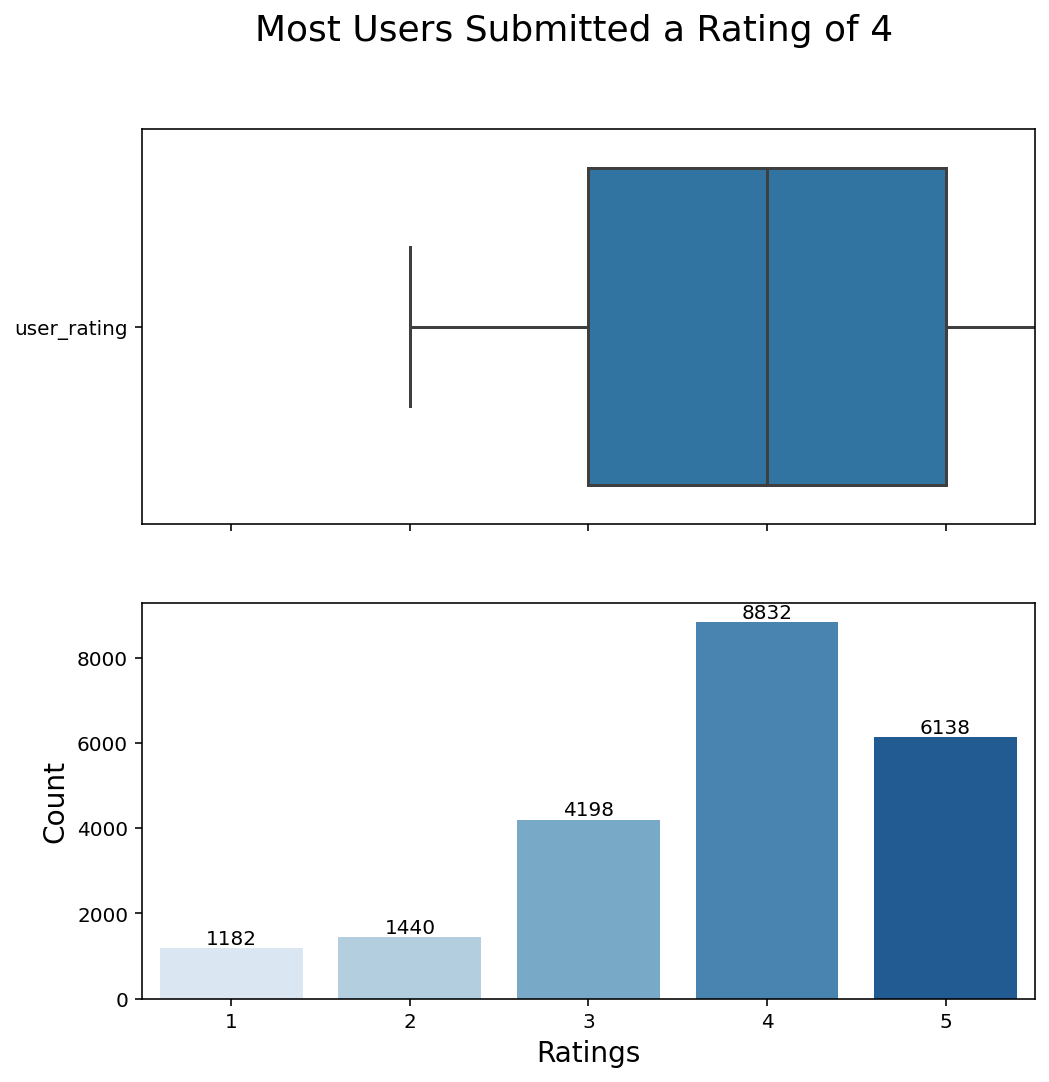

In [35]:
# Plotting the distribution

# Boxplot and distribution plot of reviews per user with more than 4 reviews submissions
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 8))
ax = ax.ravel()

plt.suptitle("Most Users Submitted a Rating of 4", size=18)

# Box plot of reviews per user
sns.boxplot(data=rating_count_df[['user_rating']], orient='h', ax=ax[0])

sns.barplot(data=rating_count_df, x='user_rating', y='comment', palette='Blues', ax=ax[1])
ax[1].set_xlabel("Ratings", size=14)
ax[1].set_ylabel("Count", size=14)
ax[1].bar_label(ax[1].containers[0]);

plt.show()

### Reviews Density and Rating Based on Locations

Locations that are in the top 20 user ratings and number of reviews are: Tanjong Pagar, Orchard, City Hall, Little India, Chinatown, Bras Basah. These area are in the town area and may have high number of tourists.

In [36]:
# Create Dataframe grouped by various locations and sorted by user_rating
location_rating_df = df.groupby(['location']).mean()[['user_rating']].sort_values(by='user_rating', ascending=False)
location_rating_df = location_rating_df.reset_index(drop=False)
location_rating_df

,location,user_rating
0,Tanglin Halt,4.500000
1,Holland Hill,4.200000
2,Tanjong Pagar,4.123324
3,Mountbatten,4.115646
4,Orchard,4.063158
...,...,...
93,Sengkang,3.047619
94,Eunos,3.025641
95,Tuas,2.888889
96,Seletar,2.432432


In [37]:
# Create Dataframe grouped by various locations and sorted by number of reviews
location_count_df = df.groupby(['location']).count()[['comment']].sort_values(by='comment', ascending=False)
location_count_df = location_count_df.reset_index(drop=False)
location_count_df

,location,comment
0,Tanjong Pagar,1119
1,Clarke Quay,998
2,Chinatown,850
3,Orchard,760
4,Arab Street,740
...,...,...
93,Potong Pasir,9
94,Tuas,9
95,Kembangan,9
96,Buangkok,2


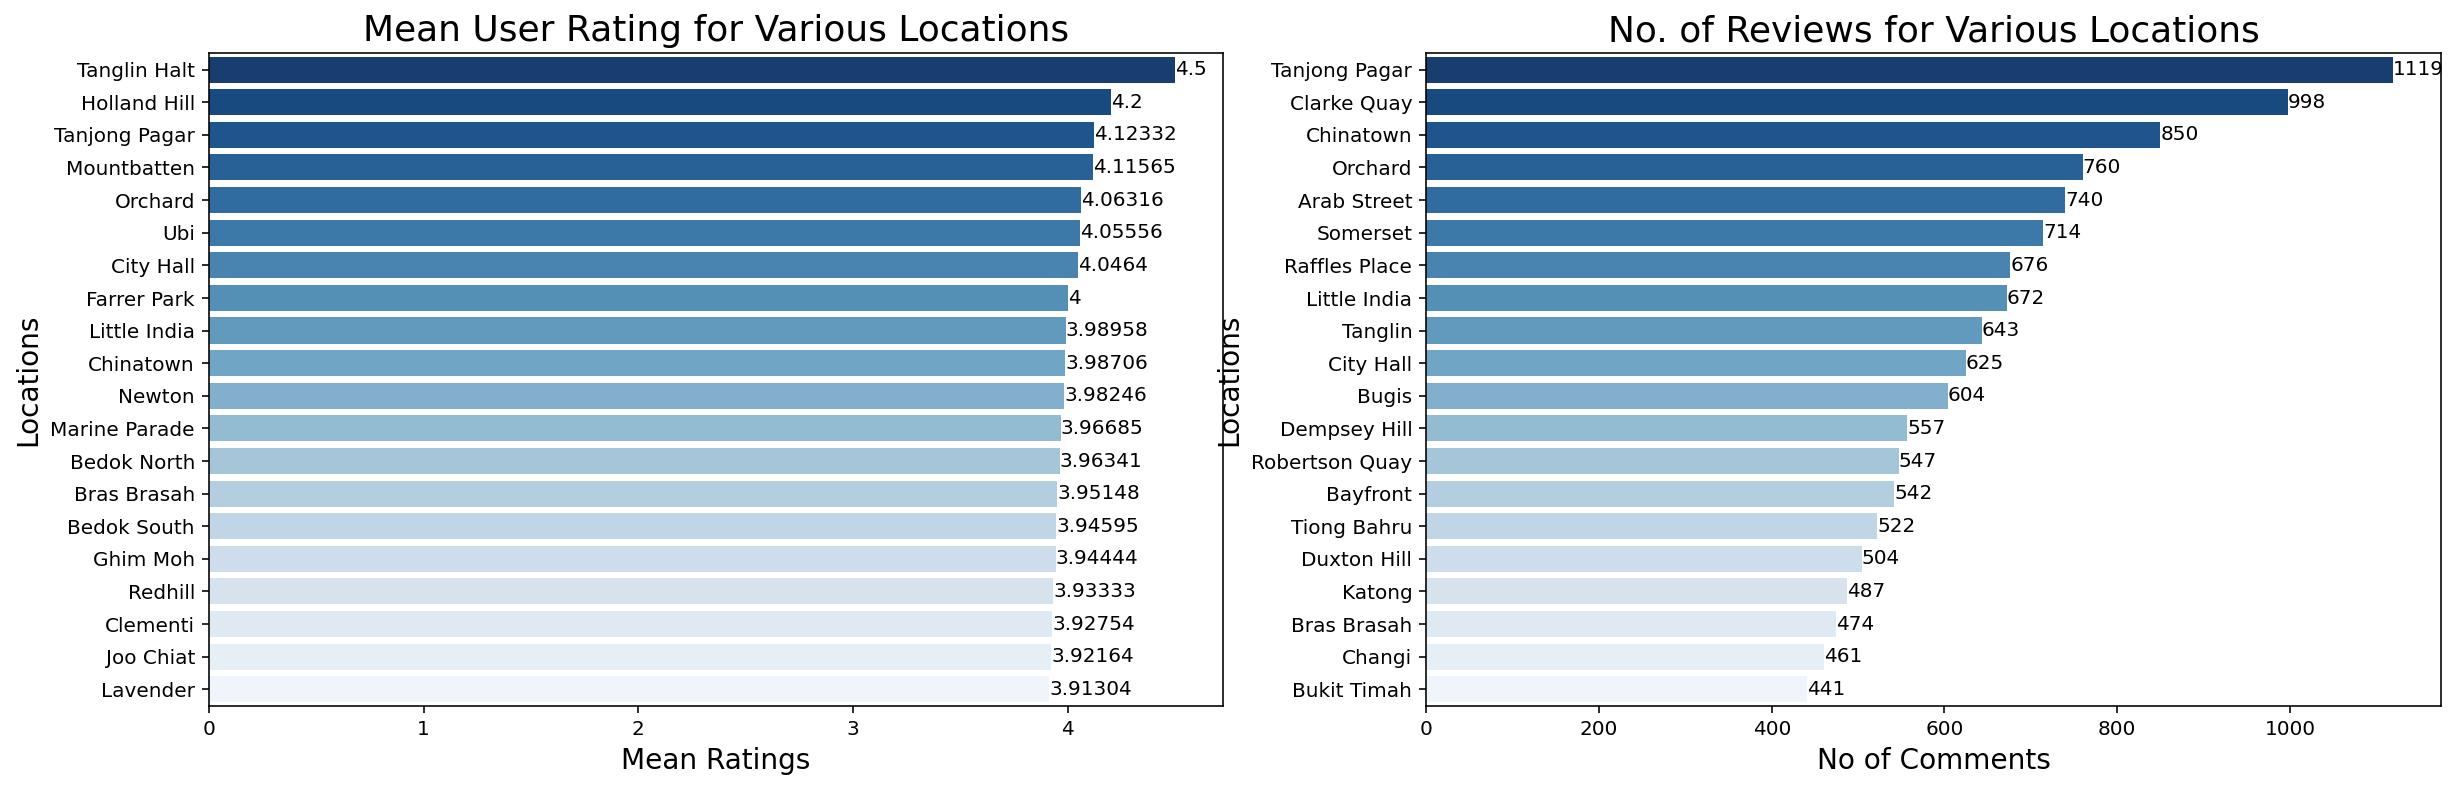

In [38]:
# Plotting the distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.barplot(data=location_rating_df.head(20), y='location', x='user_rating', palette='Blues_r', ax=ax[0])
ax[0].set_title("Mean User Rating for Various Locations", fontsize=18)
ax[0].set_xlabel("Mean Ratings", size=14)
ax[0].set_ylabel("Locations", size=14)
ax[0].bar_label(ax[0].containers[0]);

sns.barplot(data=location_count_df.head(20), y='location', x='comment', palette='Blues_r', ax=ax[1])
ax[1].set_title("No. of Reviews for Various Locations", fontsize=18)
ax[1].set_xlabel("No of Comments", size=14)
ax[1].set_ylabel("Locations", size=14)
ax[1].bar_label(ax[1].containers[0]);

plt.show()

### Top Restaurants based on Number of Reviews
1. Tian Tian Hainanese Chicken Rice, Song Fa Bak Kut Teh and Zam Zam Restaurant have the highest number of reviews. 
2. Din Tai Fung has many outlets and they have high number of reviews in general. 

In [39]:
count_rating_df = df.groupby(['rest_name', 'href']).count()[['comment']].sort_values(by='comment', ascending=False)
# count_rating_df = count_rating_df.reset_index(drop=False)
count_rating_df.head()

,,comment
rest_name,href,
Tian Tian Hainanese Chicken Rice,http://www.yelp.com/biz/tian-tian-hainanese-chicken-rice-singapore-7?osq=Restaurants,202
Song Fa Bak Kut Teh,http://www.yelp.com/biz/song-fa-bak-kut-teh-singapore-11?osq=Restaurants,128
Zam Zam Restaurant,http://www.yelp.com/biz/zam-zam-restaurant-singapore?osq=Restaurants,92
Vatos Urban Tacos,http://www.yelp.com/biz/vatos-urban-tacos-singapore?osq=Restaurants,90
Two Men Bagel House,http://www.yelp.com/biz/two-men-bagel-house-singapore?osq=Restaurants,76


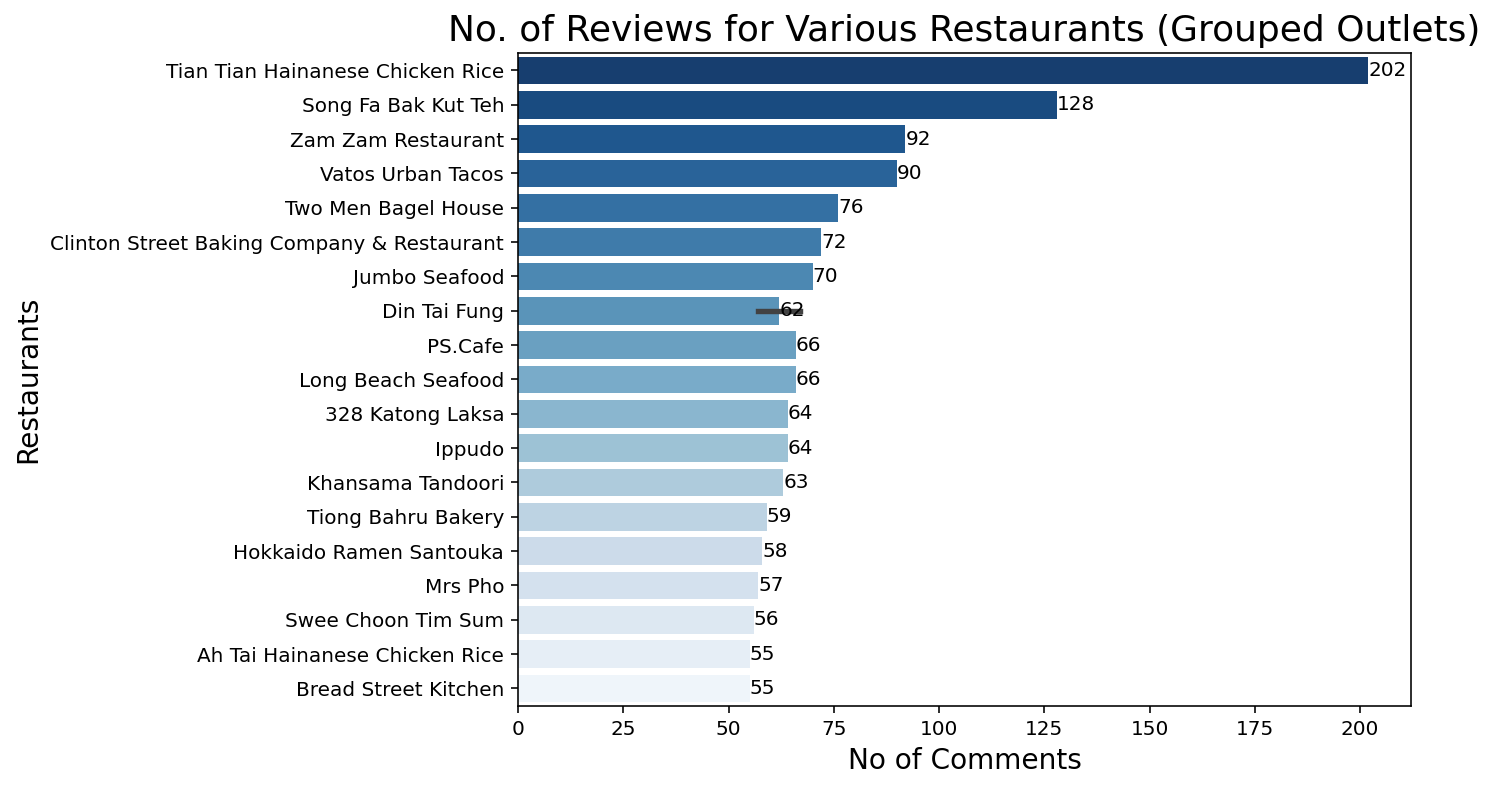

In [40]:
# Plotting the distribution

plt.figure(figsize=(8, 6))
plt.title("No. of Reviews for Various Restaurants (Grouped Outlets)", fontsize=18)

ax = sns.barplot(data=count_rating_df.reset_index(drop=False).head(20), y='rest_name', x='comment', palette='Blues_r')
ax.set_xlabel("No of Comments", size=14)
ax.set_ylabel("Restaurants", size=14)
ax.bar_label(ax.containers[0]);

plt.show()

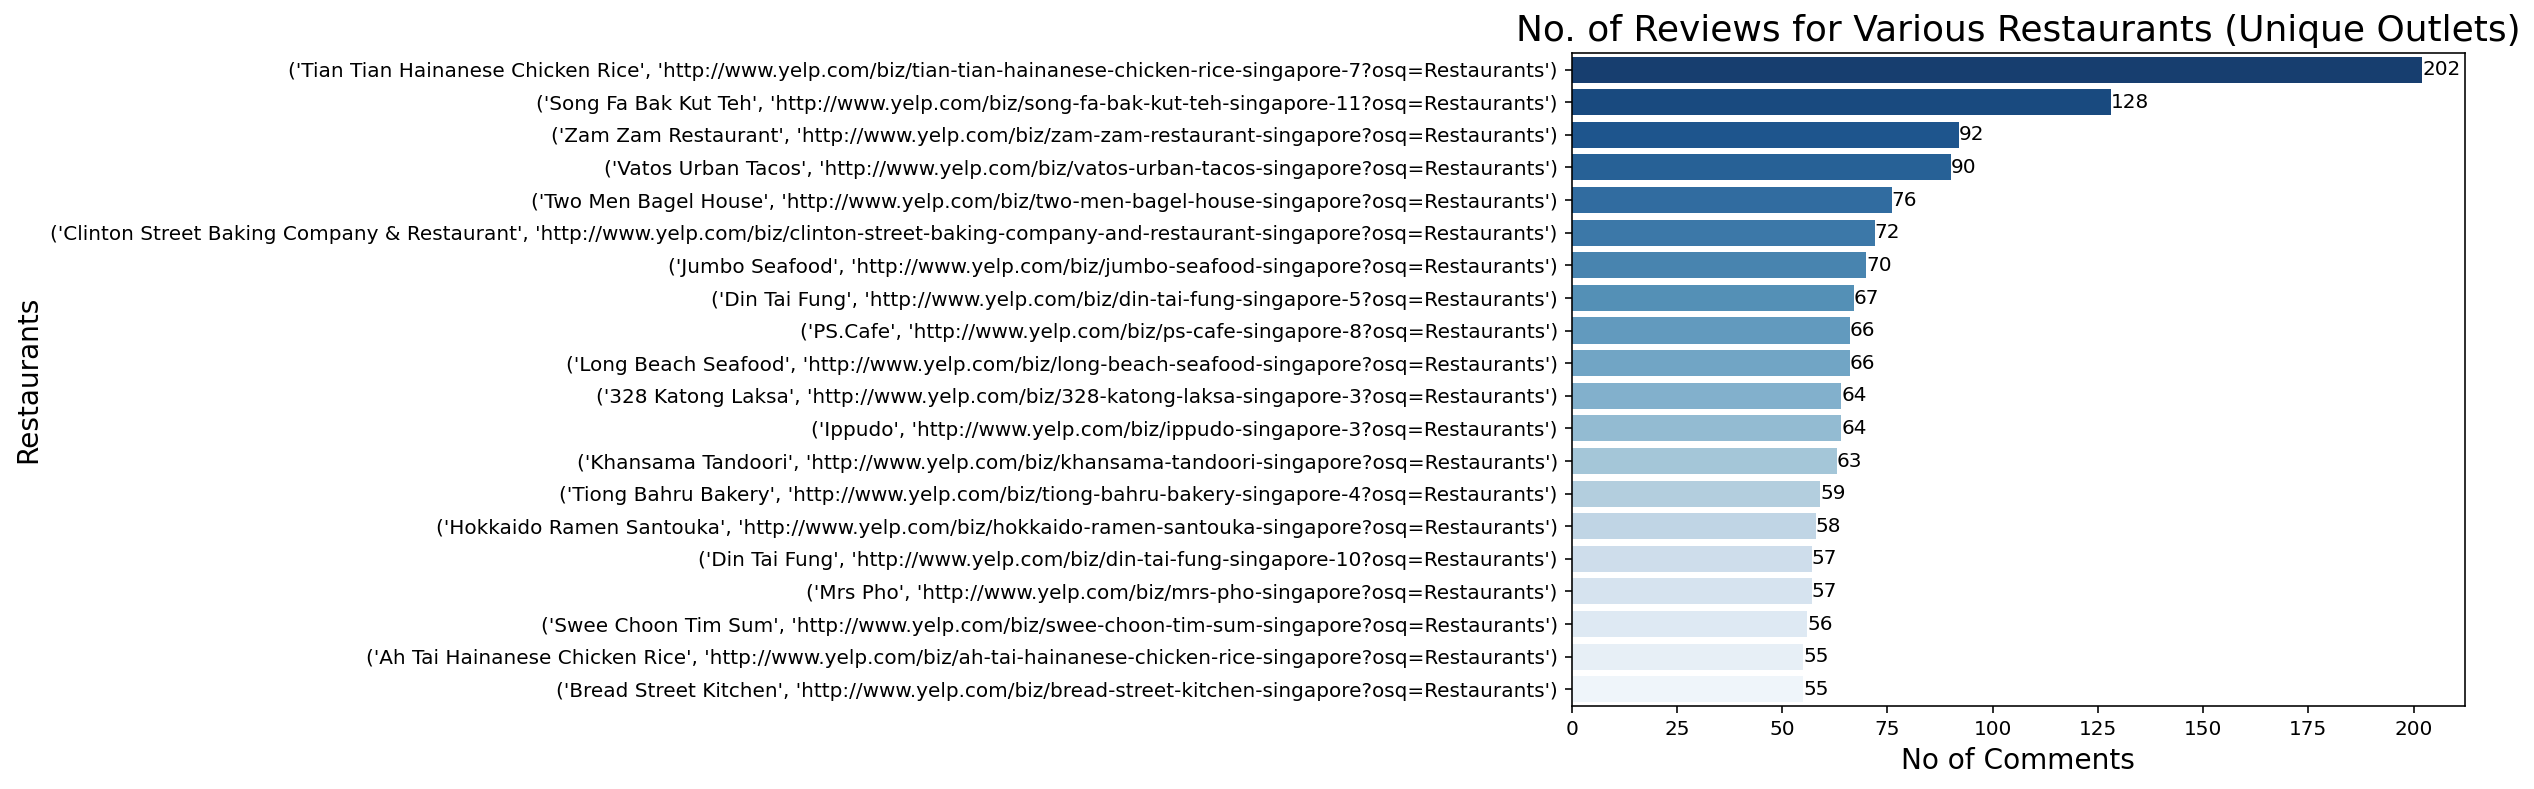

In [41]:
# Plotting the distribution

plt.figure(figsize=(8, 6))
plt.title("No. of Reviews for Various Restaurants (Unique Outlets)", fontsize=18)

ax = sns.barplot(data=count_rating_df.head(20), y=count_rating_df.head(20).index.ravel(), x='comment', palette='Blues_r')
ax.set_xlabel("No of Comments", size=14)
ax.set_ylabel("Restaurants", size=14)
ax.bar_label(ax.containers[0]);

plt.show()

### Word Count in Reviews
1. Majority of the reviews have between 30 and 100 word count. 

In [42]:
# create a set of stopwords
cust_stopwords = set(stopwords.words('english'))
cust_stopwords |= {'also', 'restaurant', 'would'}

In [43]:
## Creating new feature columns
# Calculate reviews word count

df['word_count'] = df['comment'].apply(lambda body: len([w for w in body.split(" ") if w not in cust_stopwords]))

In [44]:
# Verify column created
df[['word_count']].head()

,word_count
0,34
1,31
2,237
3,42
4,157


In [45]:
# Describe number of words per review.
df['word_count'].describe()

count    21790.000000
mean        79.000184
std         69.313642
min          3.000000
25%         32.000000
50%         59.000000
75%        102.000000
max        576.000000
Name: word_count, dtype: float64

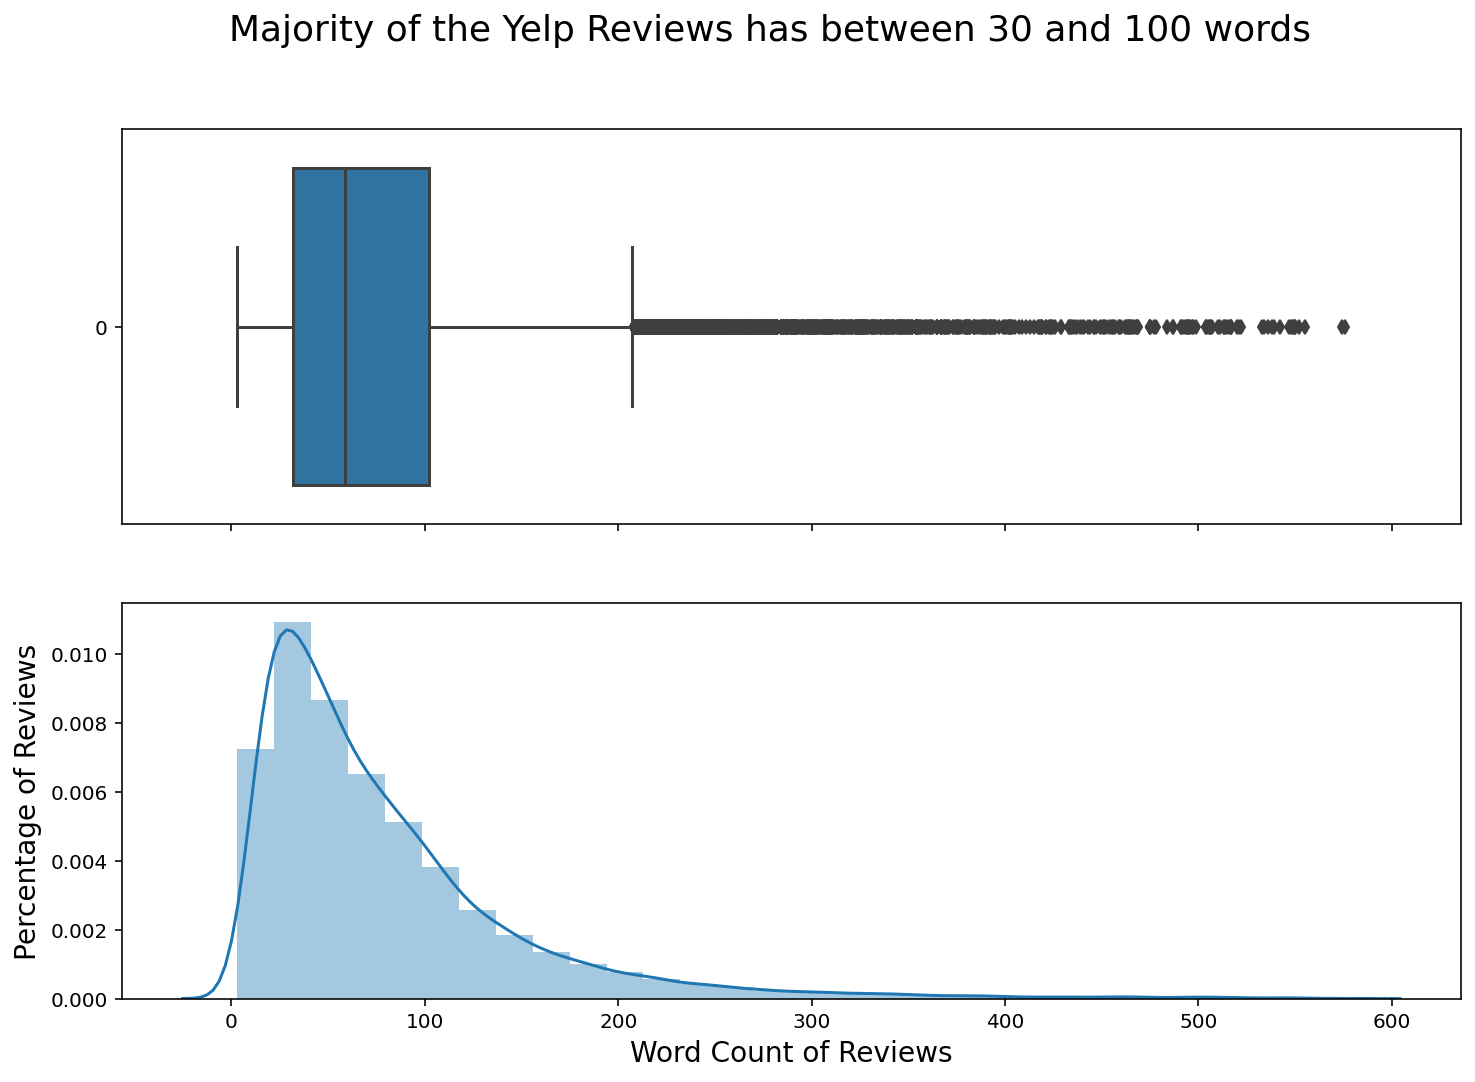

In [46]:
# Boxplot and distribution plot of word count per review with 
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
ax = ax.ravel()

plt.suptitle("Majority of the Yelp Reviews has between 30 and 100 words", size=18)

# Box plot of reviews per user
sns.boxplot(data=df['word_count'], orient='h', ax=ax[0])

# Plotting the distribution
sns.distplot(df['word_count'],
             bins=30, 
             ax=ax[1])
ax[1].set_xlabel("Word Count of Reviews", size=14)
ax[1].set_ylabel("Percentage of Reviews", size=14);

### Top Most Common Words
**Finding Most Common Word**
1. The review-related common words are place, chicken, service, rice and Singapore.
2. Bigrams and Trigrams will be explored to understand more about the comments from users. 

In [47]:
# Instantiate CountVectoriser
cv = CountVectorizer(stop_words=cust_stopwords, min_df=3)

# Fit and transform CountVectoriser
cv.fit(df['comment'])
comment_cv = cv.transform(df['comment'])

# Create Dataframe of words count.
comment_df = pd.DataFrame(comment_cv.todense(), 
                          columns=cv.get_feature_names_out())

In [48]:
# Finding top 15 common words
top_15_words = comment_df.sum().sort_values(ascending=False).head(15).to_frame('sum')
top_15_words.head(10)

,sum
food,17808
good,16394
place,12363
like,9959
one,9864
chicken,8699
service,7447
really,7357
great,6790
rice,6706


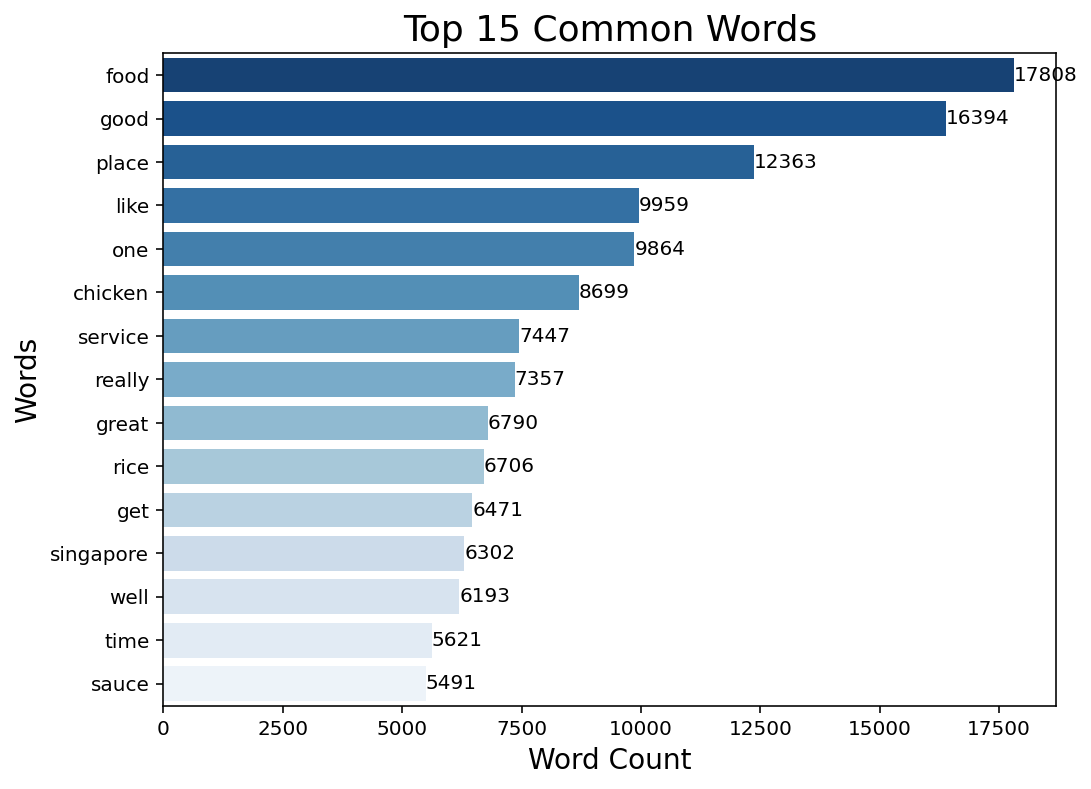

In [49]:
# plot top words. 
plt.figure(figsize=(8, 6))
plt.title("Top 15 Common Words", fontsize=18)
ax = sns.barplot(data=top_15_words, 
                 y=top_15_words.index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("Word Count", size=14)
ax.set_ylabel("Words", size=14)
ax.bar_label(ax.containers[0]);

**Finding Most Common bigrams**
1. The top 15 common meaningful bigrams are chicken rice, dim sum, ice cream and fried rice. 
2. These are food-related bigrams unique to Singapore, except for fried rice.
3. 'chicken rice' is probably the most common bigram because Tian Tian Hainanese Chicken Rice has the highest number of reviews. 




In [50]:
# Instantiate CountVectoriser
cv_bigrams = CountVectorizer(ngram_range=(2, 2), 
                              stop_words=cust_stopwords, 
                              min_df=3)

# Fit and transform CountVectoriser
cv_bigrams.fit(df['comment'])
comment_cv_bigrams = cv_bigrams.transform(df['comment'])

# Create Dataframe of words count.
comment_cv_bigrams_df = pd.DataFrame(
    comment_cv_bigrams.todense(), 
    columns=cv_bigrams.get_feature_names_out()
)

In [51]:
# Finding top 15 common words
top_15_bigrams = comment_cv_bigrams_df.sum().sort_values(ascending=False).head(15).to_frame('sum')
top_15_bigrams.head()

,sum
chicken rice,1454
ice cream,1020
pretty good,1009
dim sum,917
really good,888


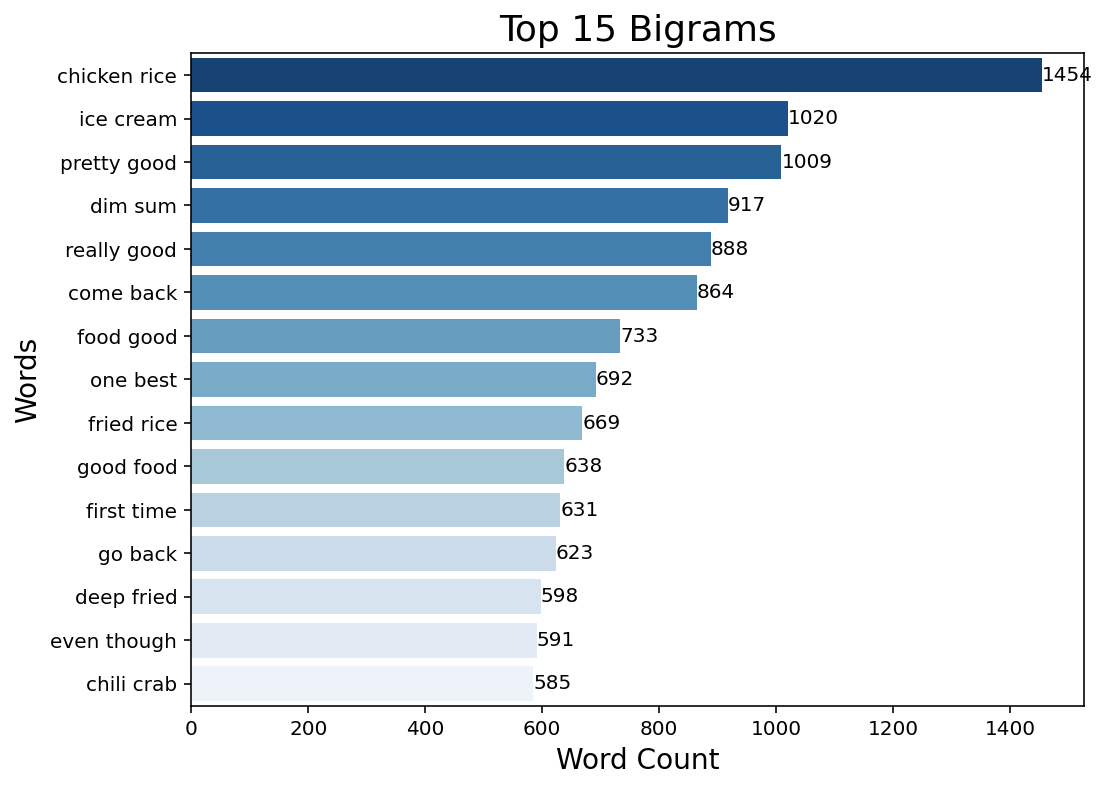

In [52]:
# plot top words. 
plt.figure(figsize=(8, 6))
plt.title("Top 15 Bigrams", fontsize=18)
ax = sns.barplot(data=top_15_bigrams, 
                 y=top_15_bigrams.index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("Word Count", size=14)
ax.set_ylabel("Words", size=14)
ax.bar_label(ax.containers[0]);

**Finding Most Common Trigrams**
1. The top 15 common trigrams are xiao long bao, ding tai fung, bak kut teh, black pepper crab, salted egg yolk. These are food-related trigrams unique to Singapore, except for xiao long bao and ding tai fung. 
2. 'bak kut teh' is the most common trigram probably because Song Fa Bak Kut Teh has one of the highest number of reviews. 
3. Other food trigrams unique to Singapore are hainanese chicken rice, char kway teow, fish head curry, vanilla ice cream, bak chor mee, yong tau foo.


In [53]:
# Instantiate CountVectoriser
cv_trigrams = CountVectorizer(ngram_range=(3, 3), 
                              stop_words=cust_stopwords, 
                              min_df=3)

# Fit and transform CountVectoriser
cv_trigrams.fit(df['comment'])
comment_cv_trigrams = cv_trigrams.transform(df['comment'])

# Create Dataframe of words count.
comment_cv_trigrams_df = pd.DataFrame(
    comment_cv_trigrams.todense(), 
    columns=cv_trigrams.get_feature_names_out()
)

In [54]:
# Finding top 15 common words
top_15_trigrams = comment_cv_trigrams_df.sum().sort_values(ascending=False).head(15).to_frame('sum')
top_15_trigrams.head()

,sum
bak kut teh,331
xiao long bao,257
black pepper crab,181
salted egg yolk,178
din tai fung,168


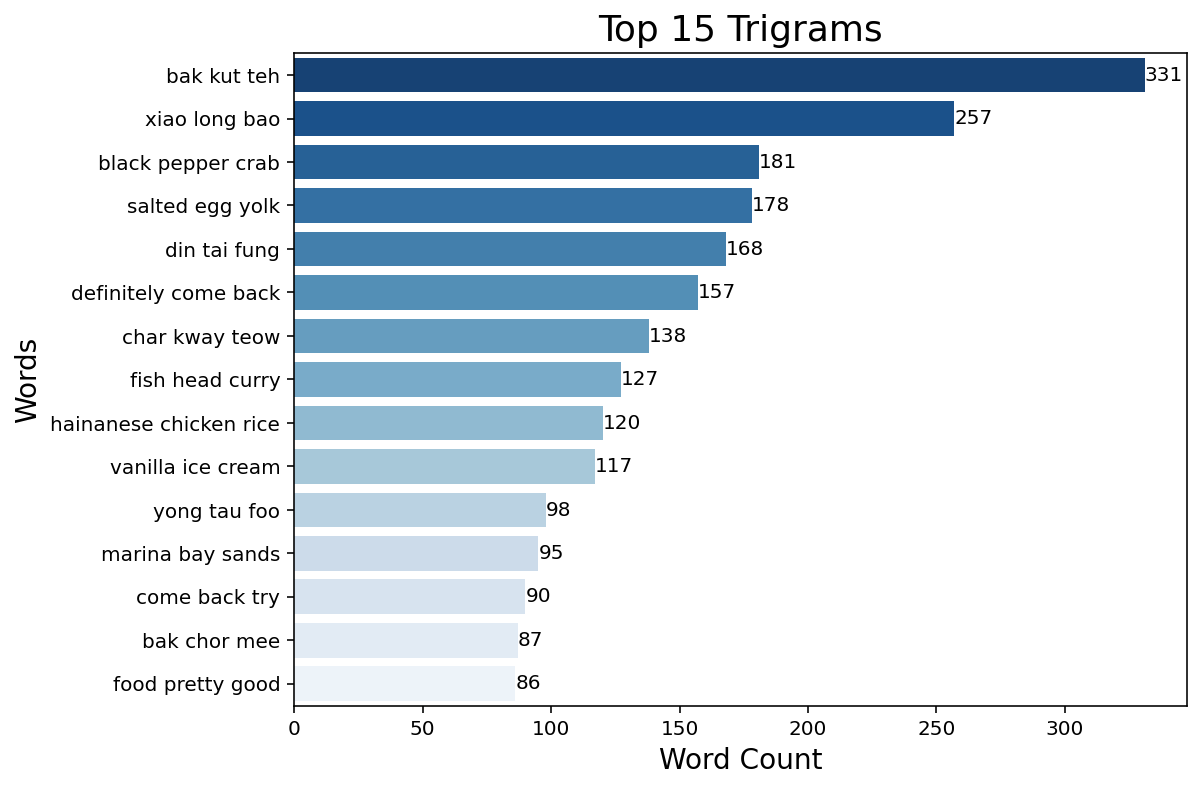

In [55]:
# plot top words. 
plt.figure(figsize=(8, 6))
plt.title("Top 15 Trigrams", fontsize=18)
ax = sns.barplot(data=top_15_trigrams, 
                 y=top_15_trigrams.index, 
                 x='sum', 
                 palette='Blues_r');
ax.set_xlabel("Word Count", size=14)
ax.set_ylabel("Words", size=14)
ax.bar_label(ax.containers[0]);

## 5. Topic Modelling

1. From the topics modelled, topics 0, 1, 3 are food related. 
2. Topics 0, 1 and 3 seems to suggest more chinese food, spicy food and western/japanese food category respectively.
3. topic 2 and 4 are related to ambience or service. 

In [56]:
# Converting words in reviews to a list

def to_words(comments):
    for comment in comments:
        comment = re.sub('\s+', ' ', comment)  # remove newline chars
        comment = re.sub("\'", "", comment)  # remove single quotes
        comment = gensim.utils.simple_preprocess(str(comment), deacc=True) 
        yield(comment)  

In [57]:
# Convert to list

comments = df['comment'].values.tolist()
data_words = list(to_words(comments))
print(data_words[:1])

[['the', 'naked', 'finnwell', 'known', 'for', 'its', 'seafood', 'for', 'dinner', 'which', 'have', 'tried', 'many', 'times', 'before', 'always', 'good', 'especially', 'their', 'cold', 'vermicelli', 'prawns', 'tiny', 'squids', 'had', 'lunch', 'here', 'for', 'the', 'first', 'time', 'limited', 'menu', 'both', 'seafood', 'local', 'food', 'lobster', 'roll', 'was', 'good', 'lobster', 'was', 'not', 'overcooked']]


In [58]:
def process_words(texts, stop_words=cust_stopwords):
    # Remove Stopwords and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    
    lemmatizer = WordNetLemmatizer()
    
    for sent in texts:
        # doc = nlp(" ".join(sent)) 
        texts_out.append([lemmatizer.lemmatize(token) for token in sent])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [59]:
# Process comments
data_processed = process_words(data_words)
data_processed[:1]

[['naked',
  'finnwell',
  'known',
  'seafood',
  'dinner',
  'tried',
  'many',
  'time',
  'always',
  'good',
  'especially',
  'cold',
  'vermicelli',
  'prawn',
  'tiny',
  'squid',
  'lunch',
  'first',
  'time',
  'limited',
  'menu',
  'seafood',
  'local',
  'food',
  'lobster',
  'roll',
  'good',
  'lobster',
  'overcooked']]

In [60]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

In [61]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=18,
                                            chunksize=250,
                                            passes=5,
                                            alpha='auto',
                                            iterations=10,
                                            per_word_topics=False)

In [62]:
# Display topics and content
topics = lda_model.show_topics(formatted=False)
topics

[(0,
  [('soup', 0.01987556),
   ('noodle', 0.01614463),
   ('dish', 0.015477962),
   ('fried', 0.013028581),
   ('pork', 0.012730303),
   ('sauce', 0.010739033),
   ('fish', 0.01021913),
   ('meat', 0.009873603),
   ('taste', 0.009828683),
   ('rice', 0.00860795)]),
 (1,
  [('chicken', 0.118784115),
   ('rice', 0.058393646),
   ('crab', 0.038498852),
   ('curry', 0.026834633),
   ('sauce', 0.020102061),
   ('thai', 0.018339079),
   ('spicy', 0.015563577),
   ('fried', 0.015139953),
   ('naan', 0.014746718),
   ('chili', 0.0137370825)]),
 (2,
  [('food', 0.03495147),
   ('good', 0.028671691),
   ('place', 0.028194929),
   ('great', 0.012651053),
   ('service', 0.011676593),
   ('really', 0.0106071895),
   ('price', 0.0100896275),
   ('drink', 0.008968599),
   ('nice', 0.008845054),
   ('pretty', 0.00841737)]),
 (3,
  [('dessert', 0.009889602),
   ('salad', 0.009592682),
   ('pizza', 0.009181025),
   ('cake', 0.009102121),
   ('japanese', 0.00833031),
   ('pasta', 0.008279103),
   ('che

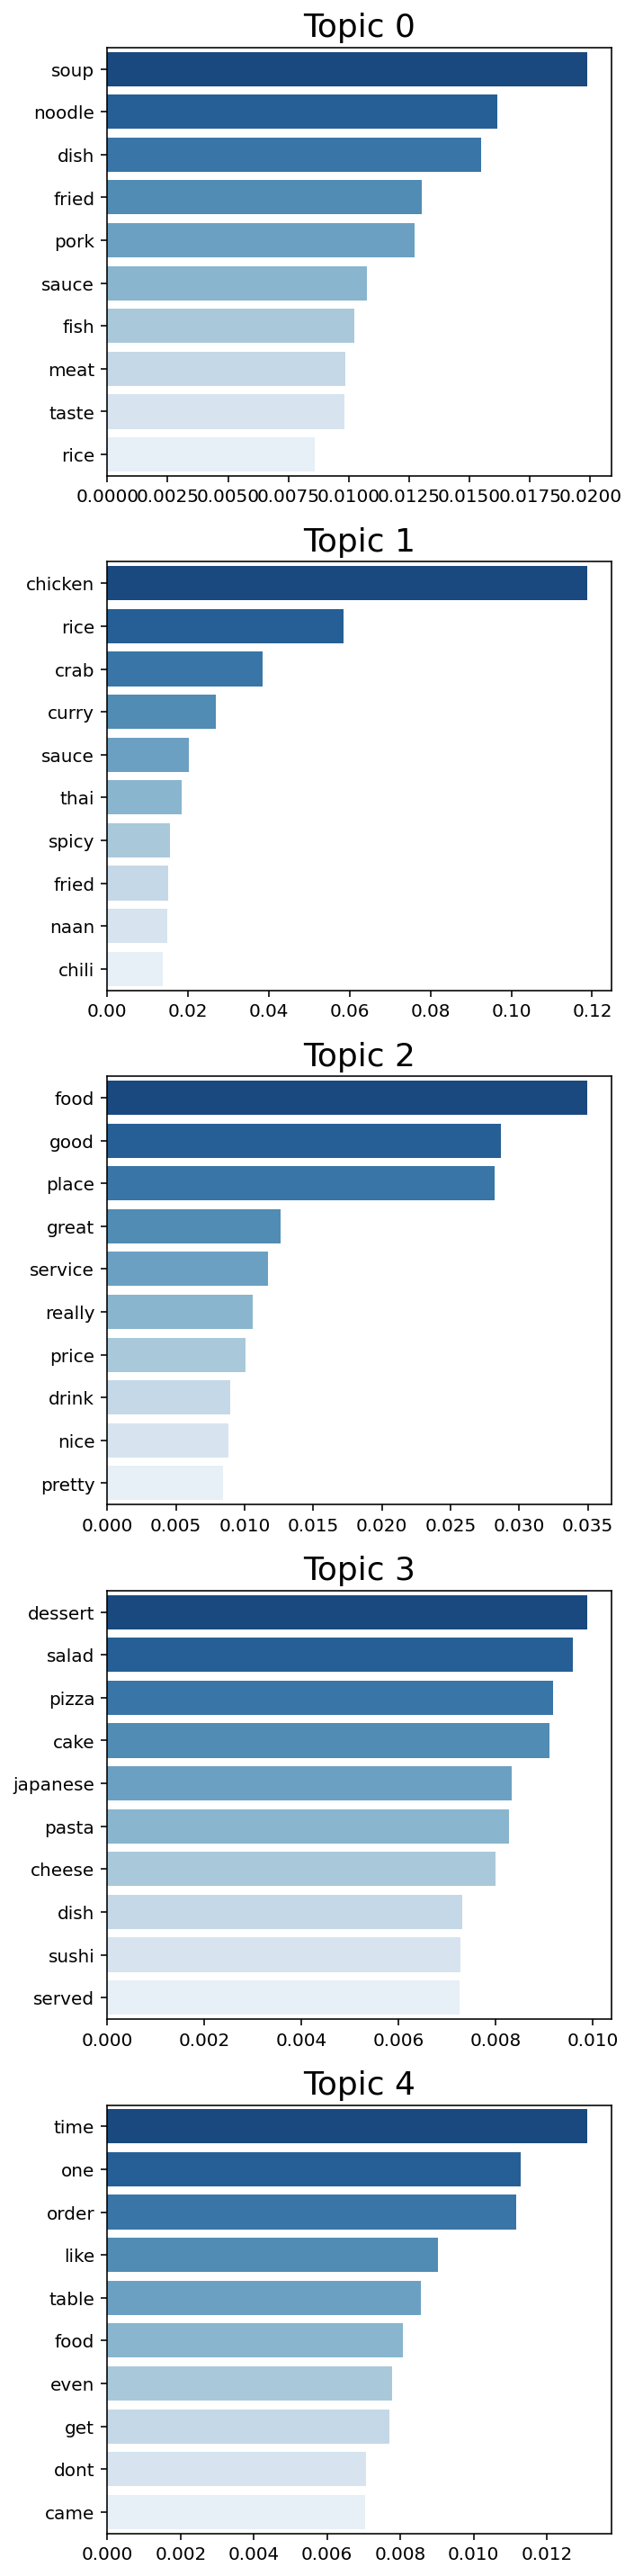

In [63]:
# Plot Top N words in each topic
fig, axes = plt.subplots(5, 1, figsize=(5,20), sharex=False, sharey=False)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    sns.barplot(x=list(list(zip(*topics[i][1]))[1]),
                y=list(list(zip(*topics[i][1]))[0]), 
                palette='Blues_r');
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=18))


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [64]:
# 5 topics

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.231393  0.098703       1        1  31.830779
2     -0.217609  0.060089       2        1  29.880674
0      0.125514 -0.130803       3        1  17.834372
3      0.025910 -0.223291       4        1  15.842204
1      0.297578  0.195303       5        1   4.611971, topic_info=         Term          Freq         Total Category  logprob  loglift
1216  chicken   8355.000000   8355.000000  Default  30.0000  30.0000
972      rice   6443.000000   6443.000000  Default  29.0000  29.0000
6        food  19844.000000  19844.000000  Default  28.0000  28.0000
38      place  14112.000000  14112.000000  Default  27.0000  27.0000
412      soup   5419.000000   5419.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
588    garlic    440.246858   1207.929542   Topic5  -5.0728   2.0672
85       dish    956.767660   8919.877168   Topic5  -4.2966   0.8440
136      meat    520.859988   4172.127568   Topic5  -4.9046   0.9958
302    tender    333.034436   1880.692463   Topic5  -5.3519   1.3454
73     chilli    316.878969   1320.850123   Topic5  -5.4016   1.6490

[359 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
974       2  0.995269  affordable
974       3  0.001684  affordable
974       4  0.003368  affordable
796       1  0.997115         ago
1269      1  0.999180     already
...     ...       ...         ...
428       1  0.998335        yelp
228       1  0.993540         yes
228       4  0.005992         yes
2691      3  0.284277         yum
2691      5  0.713479         yum

[647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 4, 2])

In [65]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=comments):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        if i%200==0:
            print(f'Completed {i}/{len(ldamodel[corpus])}.')
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['dominant_topic', 'topic_keywords', 'tokens']
    
    print(f'Complete formatting.')
    
    return(sent_topics_df)

In [66]:
# Get columns for topic number and topic_keywords
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_processed)

Completed 0/21790.
Completed 200/21790.
Completed 400/21790.
Completed 600/21790.
Completed 800/21790.
Completed 1000/21790.
Completed 1200/21790.
Completed 1400/21790.
Completed 1600/21790.
Completed 1800/21790.
Completed 2000/21790.
Completed 2200/21790.
Completed 2400/21790.
Completed 2600/21790.
Completed 2800/21790.
Completed 3000/21790.
Completed 3200/21790.
Completed 3400/21790.
Completed 3600/21790.
Completed 3800/21790.
Completed 4000/21790.
Completed 4200/21790.
Completed 4400/21790.
Completed 4600/21790.
Completed 4800/21790.
Completed 5000/21790.
Completed 5200/21790.
Completed 5400/21790.
Completed 5600/21790.
Completed 5800/21790.
Completed 6000/21790.
Completed 6200/21790.
Completed 6400/21790.
Completed 6600/21790.
Completed 6800/21790.
Completed 7000/21790.
Completed 7200/21790.
Completed 7400/21790.
Completed 7600/21790.
Completed 7800/21790.
Completed 8000/21790.
Completed 8200/21790.
Completed 8400/21790.
Completed 8600/21790.
Completed 8800/21790.
Completed 9000/21

In [67]:
# Display first 5 and last 5 rows of dataframe
df_topic_sents_keywords

,dominant_topic,topic_keywords,tokens
0,2,"food, good, place, great, service, really, pri...","[naked, finnwell, known, seafood, dinner, trie..."
1,4,"time, one, order, like, table, food, even, get...","[place, quite, difficult, book, even, weekday,..."
2,3,"dessert, salad, pizza, cake, japanese, pasta, ...","[love, space, anyone, remember, klee, defunct,..."
3,4,"time, one, order, like, table, food, even, get...","[really, want, like, place, couldnt, yes, appr..."
4,4,"time, one, order, like, table, food, even, get...","[naked, finn, run, ken, loon, met, friend, sin..."
...,...,...,...
21785,4,"time, one, order, like, table, food, even, get...","[came, lunch, yakitori, stick, nothing, much, ..."
21786,2,"food, good, place, great, service, really, pri...","[couple, time, love, mookata, comparable, one,..."
21787,0,"soup, noodle, dish, fried, pork, sauce, fish, ...","[taste, jjimdak, seoul, jjimdak, mixture, bone..."
21788,2,"food, good, place, great, service, really, pri...","[loved, jimdak, portion, tender, succulent, ch..."


In [68]:
# Append new columns onto df
extra_feature_columns = df_topic_sents_keywords[['dominant_topic', 'topic_keywords']]
final_df = pd.concat([df,extra_feature_columns], axis=1)#.reindex(combined_reviews.index)
final_df.head(10)

,rest_name,href,address,postal_code,latitude,longitude,opening,img,star_rating,review_count,...,category_irish,category_barbeque,category_mediterranean,category_thai,category_greek,category_food_stands,local_user,word_count,dominant_topic,topic_keywords
0,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,34,2,"food, good, place, great, service, really, pri..."
1,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,31,4,"time, one, order, like, table, food, even, get..."
2,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,237,3,"dessert, salad, pizza, cake, japanese, pasta, ..."
3,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,0,42,4,"time, one, order, like, table, food, even, get..."
4,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,0,157,4,"time, one, order, like, table, food, even, get..."
5,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,103,2,"food, good, place, great, service, really, pri..."
6,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,0,172,4,"time, one, order, like, table, food, even, get..."
7,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,0,51,3,"dessert, salad, pizza, cake, japanese, pasta, ..."
8,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,85,2,"food, good, place, great, service, really, pri..."
9,The Naked Finn,http://www.yelp.com/biz/the-naked-finn-singapo...,39 Malan Rd Singapore 109442 Singapore,109442,1.276081,103.804434,"[('Mon', ['12:00 PM - 3:00 PM', '6:00 PM - 10:...",https://s3-media0.fl.yelpcdn.com/bphoto/ScSHvC...,4.5,19.0,...,0,0,0,0,0,0,1,97,2,"food, good, place, great, service, really, pri..."


In [69]:
# Save final_reviews into csv file
final_df.to_csv('../data/final_df.csv', index=False)

# <center> END OF NOTEBOOK </center>